# Step 1: Import Necessary Libraries

In [1]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import data_preprocessing_emlakjet as dpe

import seaborn as sns


import pandas as pd
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ensure NLTK resources are available
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/melih/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/melih/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Step 2: Load and Prepare the Data

## Load the JSON data

In [3]:

# Load the raw data
raw_data = dpe.load_json_data('istanbul_emlakjet_all_records_updated.json')

# Preprocess the data
processed_data = dpe.cleanse_and_preprocess_data(raw_data)

df = pd.DataFrame(processed_data)

# Display the first few rows of the DataFrame
df.head()


,id,categoryTypeName,tradeTypeName,estateTypeName,title,url,images,locationSummary,quickInfos,priceDetail,description,info,location,ilanda_kalis_suresi,ilan_bitis,is_active
0,16176818,konut,satılık,daire,heybeli̇ada satilik orta kat dai̇re,https://imaj.emlakjet.com/ilan/heybeliada-sati...,[https://imaj.emlakjet.com/listing/16176818/4B...,adalar - heybeliada mahallesi,Oda Sayısı: 2+1; Bulunduğu Kat: 2. Kat,"{'trendType': None, 'previousCurrency': None, ...",heybeli̇ada plaj ve klube yakin i̇ki̇ oda bi̇r...,"{'id': '16176818', 'created_at': '2024-10-29',...","{'summary': 'Adalar - Heybeliada Mahallesi', '...",26,None,True
1,16170470,konut,satılık,müstakil ev,heybeli̇ada satilik müstaki̇l bi̇na,https://imaj.emlakjet.com/ilan/heybeliada-sati...,[https://imaj.emlakjet.com/listing/16170470/09...,adalar - heybeliada mahallesi,Oda Sayısı: 3+1,"{'trendType': None, 'previousCurrency': None, ...",heybeli̇ada merkeze yakin tek katli müstaki̇l ...,"{'id': '16170470', 'created_at': '2024-10-27',...","{'summary': 'Adalar - Heybeliada Mahallesi', '...",28,None,True
2,16149397,konut,satılık,daire,büyükada lido teras sitesinde panoramik deniz ...,https://imaj.emlakjet.com/ilan/buyukada-lido-t...,[https://imaj.emlakjet.com/listing/16149397/4B...,adalar - nizam mahallesi,Oda Sayısı: 2+1; Bulunduğu Kat: 2. Kat,"{'trendType': None, 'previousCurrency': None, ...",posei̇don gayri̇menkul ve i̇nşaat ofi̇si̇\n\nt...,"{'id': '16149397', 'created_at': '2024-10-24',...","{'summary': 'Adalar - Nizam Mahallesi', 'city'...",31,None,True
3,16115980,konut,satılık,daire,tekinay'da bakımlı 4+1 köşe konumlu manzaralı ...,https://imaj.emlakjet.com/ilan/tekinay-da-baki...,[https://imaj.emlakjet.com/listing/16115980/E3...,adalar - kınalıada mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: Bahçe katı,"{'trendType': None, 'previousCurrency': None, ...",tekinay'da 4+1 köşe konumlu manzaralı ferah sa...,"{'id': '16115980', 'created_at': '2024-10-18',...","{'summary': 'Adalar - Kınalıada Mahallesi', 'c...",37,None,True
4,16112618,konut,satılık,daire,heybeli̇ada'da yatirimlik ve oturumluk eşyali ...,https://imaj.emlakjet.com/ilan/heybeliada-da-y...,[https://imaj.emlakjet.com/listing/16112618/F4...,adalar - heybeliada mahallesi,Oda Sayısı: 2+1; Bulunduğu Kat: 2. Kat,"{'trendType': None, 'previousCurrency': None, ...",yeni̇tepe gayri̇menkul 'den\n\n \n \n\nfull e...,"{'id': '16112618', 'created_at': '2024-10-18',...","{'summary': 'Adalar - Heybeliada Mahallesi', '...",37,2024-11-24,False


## Data Preparation

In [4]:
print(df.columns)

Index(['id', 'categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title',
       'url', 'images', 'locationSummary', 'quickInfos', 'priceDetail',
       'description', 'info', 'location', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active'],
      dtype='object')


In [5]:
if 'priceDetail' in df.columns:
    price_details = pd.json_normalize(df['priceDetail'])
    df = pd.concat([df.drop(['priceDetail'], axis=1), price_details], axis=1)

if 'info' in df.columns:
    info_details = pd.json_normalize(df['info'])
    df = pd.concat([df.drop(['info'], axis=1), info_details], axis=1)


In [6]:
# Average Household Size Related Feature Implementation

# Step 1: Load the district-level average household size data from Excel
household_size_df = pd.read_excel('2022-yl-ilcelere-gore-ortalama-hanehalk-buyukluu.xlsx')

# Rename columns to match better with our dataset
household_size_df.rename(columns={
    'İlçe': 'district_name',
    'Ortalama Hanehalkı Büyüklüğü 2022': 'average_household_size'
}, inplace=True)

# Step 2: Extract district information from the listings
# Extract district information before flattening location details
df['district_name'] = df['location'].apply(lambda x: x['district']['name'])

# Step 3: Merge average household size information into the DataFrame
df = df.merge(household_size_df, on='district_name', how='left')

# Step 4: Handle missing values after the merge
missing_districts_count = df['average_household_size'].isna().sum()

if missing_districts_count > 0:
    print(f"Warning: {missing_districts_count} districts in the property data do not have matching household size information.")
else:
    print("Success: All districts in the property data have matching household size information.")

# Fill missing values with mean
df['average_household_size'].fillna(df['average_household_size'].mean(), inplace=True)


Success: All districts in the property data have matching household size information.


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/722638337.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['average_household_size'].fillna(df['average_household_size'].mean(), inplace=True)


In [7]:
from unidecode import unidecode
# Step 1: Load the district-level population data from Excel
population_data_df = pd.read_excel('2021ISTANBULILCEYERLESIMVENUFUSBILGILERI.xlsx', header=1)

# Step 2: Manually set the column names since there are formatting issues with the file
population_data_df.columns = [
    'district_name', 'population_2020', 'population_count_2021', 'difference', 'population_growth_rate',
    'neighborhood_count', 'area_km2', 'population_density'
]

# Step 3: Normalize district names by making them lowercase, stripping spaces, and removing diacritics
population_data_df['district_name'] = population_data_df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())
df['district_name'] = df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 4: Filter out rows with missing district names
population_data_df = population_data_df[~population_data_df['district_name'].isna()]

# Step 5: Extract relevant columns
population_data_df = population_data_df[['district_name', 'population_density', 'population_count_2021', 'population_growth_rate']]

# Step 6: Merge population data into the main DataFrame
df = df.merge(population_data_df, on='district_name', how='left')

# Step 7: Handle any missing values after the merge
missing_density_count = df['population_density'].isna().sum()
missing_population_count = df['population_count_2021'].isna().sum()
missing_growth_rate = df['population_growth_rate'].isna().sum()

if missing_density_count > 0:
    print(f"Warning: {missing_density_count} districts in the property data do not have matching population density information.")
else:
    print("Success: All districts in the property data have matching population density information.")

if missing_population_count > 0:
    print(f"Warning: {missing_population_count} districts in the property data do not have matching population count information.")
else:
    print("Success: All districts in the property data have matching population count information.")

if missing_growth_rate > 0:
    print(f"Warning: {missing_growth_rate} districts in the property data do not have matching population growth rate information.")
else:
    print("Success: All districts in the property data have matching population growth rate information.")

# Step 8: Display districts that are missing information
missing_population_density_df = df[df['population_density'].isna()]
if not missing_population_density_df.empty:
    print("List of districts without matching population data:")
    print(missing_population_density_df['district_name'].unique())

df['population_density'].fillna(df['population_density'].mean(), inplace=True)
df['population_count_2021'].fillna(df['population_count_2021'].mean(), inplace=True)
df['population_growth_rate'].fillna(df['population_growth_rate'].mean(), inplace=True)

# Display the updated DataFrame with the new features
print(df[['district_name', 'average_household_size', 'population_density', 'population_count_2021', 'population_growth_rate']].head())


Success: All districts in the property data have matching population density information.
Success: All districts in the property data have matching population count information.
Success: All districts in the property data have matching population growth rate information.
  district_name  average_household_size  population_density  \
0        adalar                    2.35                1488   
1        adalar                    2.35                1488   
2        adalar                    2.35                1488   
3        adalar                    2.35                1488   
4        adalar                    2.35                1488   

   population_count_2021  population_growth_rate  
0                 16.372                    2.11  
1                 16.372                    2.11  
2                 16.372                    2.11  
3                 16.372                    2.11  
4                 16.372                    2.11  


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/2266928406.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['population_density'].fillna(df['population_density'].mean(), inplace=True)
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/2266928406.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [8]:
import pandas as pd
from unidecode import unidecode

# Step 1: Load the district-level social assistance data from Excel
social_assistance_df = pd.read_excel('21-vdym-ilce-baznda-hanelerin-kamu-kurumlarndan-sosyal-yardm-alma-durumu.xlsx')

# Step 2: Rename columns for easier access
social_assistance_df.rename(columns={
    'İlçe': 'district_name',
    'Sosyal Yardım Alma_Evet': 'social_assistance_yes',
    'Sosyal Yardım Alma_Hayır': 'social_assistance_no'
}, inplace=True)

# Step 3: Normalize district names in the social assistance DataFrame
social_assistance_df['district_name'] = social_assistance_df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 4: Normalize district names in the main DataFrame
df['district_name'] = df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 5: Merge social assistance data into the main DataFrame
df = df.merge(social_assistance_df, on='district_name', how='left')

# Step 6: Handle any missing values after the merge
missing_social_assistance_count = df['social_assistance_yes'].isna().sum()

if missing_social_assistance_count > 0:
    print(f"Warning: {missing_social_assistance_count} districts in the property data do not have matching social assistance information.")
else:
    print("Success: All districts in the property data have matching social assistance information.")

df['social_assistance_yes'].fillna(0, inplace=True)
df['social_assistance_no'].fillna(0, inplace=True)

# Display the updated DataFrame with the new feature
print(df[['district_name', 'average_household_size', 'social_assistance_yes', 'social_assistance_no']].head())


Success: All districts in the property data have matching social assistance information.
  district_name  average_household_size  social_assistance_yes  \
0        adalar                    2.35                      9   
1        adalar                    2.35                      9   
2        adalar                    2.35                      9   
3        adalar                    2.35                      9   
4        adalar                    2.35                      9   

   social_assistance_no  
0                   353  
1                   353  
2                   353  
3                   353  
4                   353  


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/256647811.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['social_assistance_yes'].fillna(0, inplace=True)
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/256647811.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [9]:
import pandas as pd
from unidecode import unidecode

# Step 1: Load the district-level average household size in square meters data from Excel
household_size_area_df = pd.read_excel('9-vdym-ilce-bazl-ortalama-hane-buyuklukleri-m2.xlsx')

# Step 2: Rename columns for easier access
household_size_area_df.rename(columns={
    'İlçe': 'district_name',
    'Ortalama Brüt (m2)': 'average_gross_area_m2',
    'Ortalama Net (m2)': 'average_net_area_m2'
}, inplace=True)

# Step 3: Normalize district names in the household size area DataFrame using unidecode
household_size_area_df['district_name'] = household_size_area_df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 4: Normalize district names in the main DataFrame using unidecode
df['district_name'] = df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 5: Merge household size area data into the main DataFrame
df = df.merge(household_size_area_df, on='district_name', how='left')

# Step 6: Handle any missing values after the merge
missing_household_size_area_count = df['average_gross_area_m2'].isna().sum()

if missing_household_size_area_count > 0:
    print(f"Warning: {missing_household_size_area_count} districts in the property data do not have matching household size area information.")
else:
    print("Success: All districts in the property data have matching household size area information.")

df['average_gross_area_m2'].fillna(df['average_gross_area_m2'].mean(), inplace=True)
df['average_net_area_m2'].fillna(df['average_net_area_m2'].mean(), inplace=True)

# Display the updated DataFrame with the new features
print(df[['district_name', 'average_household_size', 'average_gross_area_m2', 'average_net_area_m2']].head())


Success: All districts in the property data have matching household size area information.
  district_name  average_household_size  average_gross_area_m2  \
0        adalar                    2.35                     94   
1        adalar                    2.35                     94   
2        adalar                    2.35                     94   
3        adalar                    2.35                     94   
4        adalar                    2.35                     94   

   average_net_area_m2  
0                   82  
1                   82  
2                   82  
3                   82  
4                   82  


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/3461291857.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['average_gross_area_m2'].fillna(df['average_gross_area_m2'].mean(), inplace=True)
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/3461291857.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

In [10]:
from unidecode import unidecode

# Step 1: Load the district-level data from the CSV file
district_data_df = pd.read_csv('ilce_data.csv')

# Step 2: Rename columns for easier access
district_data_df.rename(columns={
    'District': 'district_name',
    'n': 'sample_size',
    'Sosyo-demografi': 'socio_demographic_score',
    'Sosyo-ekonomi': 'socio_economic_score',
    'Risk Algısı ve Tutumlar': 'risk_perception_attitudes',
    'Değerler': 'values_score',
    'Score': 'overall_score'
}, inplace=True)

# Step 3: Normalize district names in the district data DataFrame using unidecode
district_data_df['district_name'] = district_data_df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 4: Normalize district names in the main DataFrame (`df`) using unidecode
df['district_name'] = df['district_name'].apply(lambda x: unidecode(str(x)).lower().strip())

# Step 5: Merge district data into the main DataFrame (`df`)
df = df.merge(district_data_df, on='district_name', how='left')

# Step 6: Handle any missing values after the merge
missing_district_data_count = df['socio_demographic_score'].isna().sum()

if missing_district_data_count > 0:
    print(f"Warning: {missing_district_data_count} districts in the property data do not have matching district-level information.")
else:
    print("Success: All districts in the property data have matching district-level information.")

# Optionally fill missing values with the mean or another strategy
df['socio_demographic_score'].fillna(df['socio_demographic_score'].mean(), inplace=True)
df['socio_economic_score'].fillna(df['socio_economic_score'].mean(), inplace=True)
df['risk_perception_attitudes'].fillna(df['risk_perception_attitudes'].mean(), inplace=True)
df['values_score'].fillna(df['values_score'].mean(), inplace=True)
df['overall_score'].fillna(df['overall_score'].mean(), inplace=True)

# Display the updated DataFrame with the new features
print(df[['district_name', 'socio_demographic_score', 'socio_economic_score', 'risk_perception_attitudes', 'values_score', 'overall_score']].head())


  district_name  socio_demographic_score  socio_economic_score  \
0        adalar                     45.2                 48.26   
1        adalar                     45.2                 48.26   
2        adalar                     45.2                 48.26   
3        adalar                     45.2                 48.26   
4        adalar                     45.2                 48.26   

   risk_perception_attitudes  values_score  overall_score  
0                      45.79         49.59          45.05  
1                      45.79         49.59          45.05  
2                      45.79         49.59          45.05  
3                      45.79         49.59          45.05  
4                      45.79         49.59          45.05  


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/1221288647.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['socio_demographic_score'].fillna(df['socio_demographic_score'].mean(), inplace=True)
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/1221288647.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate ob

In [11]:
# Extract and encode location-based features
from sklearn.preprocessing import LabelEncoder

# Extract district, locality, and town names
df['district_name'] = df['location'].apply(lambda x: x.get('district', {}).get('name', None))
df['locality_name'] = df['location'].apply(lambda x: x.get('locality', {}).get('name', None))
df['town_name'] = df['location'].apply(lambda x: x.get('town', {}).get('name', None))

# Initialize LabelEncoders
district_encoder = LabelEncoder()
locality_encoder = LabelEncoder()
town_encoder = LabelEncoder()

# Encode the location features
df['district_name_encoded'] = district_encoder.fit_transform(df['district_name'].astype(str))
df['locality_name_encoded'] = locality_encoder.fit_transform(df['locality_name'].astype(str))
df['town_name_encoded'] = town_encoder.fit_transform(df['town_name'].astype(str))

# Verify that location-based features are added
print(df[['district_name_encoded', 'locality_name_encoded', 'town_name_encoded']].head())

df['district_name_encoded'].unique()


   district_name_encoded  locality_name_encoded  town_name_encoded
0                      0                    158                276
1                      0                    158                276
2                      0                     66                431
3                      0                    204                374
4                      0                    158                276


array([ 0,  1,  2,  3,  7,  4,  5,  8,  6, 12,  9, 10, 11, 13, 33, 34, 14,
       15, 16, 17, 18, 19, 20, 22, 21, 23, 24, 25, 26, 27, 37, 28, 38, 29,
       30, 31, 35, 36, 32])

In [12]:
#LOCATION
if 'location' in df.columns:
    location_details = pd.json_normalize(df['location'])
    df = pd.concat([df.drop(['location'], axis=1), location_details], axis=1)

if 'coordinate.lat' in df.columns and 'coordinate.lon' in df.columns:
    df['lat'] = df['coordinate.lat']
    df['lon'] = df['coordinate.lon']
    df = df.drop(['coordinate.lat', 'coordinate.lon'], axis=1)

import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# Load the Excel file
park_df = pd.read_excel('istanbul-park-ve-yeil-alan-koordinatlar.xlsx')

# Step 2: Filter only park-related entries, handling NaN values
park_df = park_df[park_df['TÜR '].fillna('').str.contains('Park', case=False)]

# Step 3: Ensure latitude and longitude are numeric
park_df['LATITUDE'] = pd.to_numeric(park_df['LATITUDE'], errors='coerce')
park_df['LONGITUDE'] = pd.to_numeric(park_df['LONGITUDE'], errors='coerce')

# Step 4: Drop rows with NaN values in LATITUDE or LONGITUDE
park_df = park_df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to numpy array
park_coords = park_df[['LONGITUDE', 'LATITUDE']].to_numpy()

# Step 5: Verify that all values are finite
if not np.all(np.isfinite(park_coords)):
    raise ValueError("There are still non-finite values in park coordinates.")

# Step 6: Create a KDTree for efficient nearest-neighbor search
park_tree = cKDTree(park_coords)

# Step 7: Define a function to calculate the distance to the nearest park
def find_nearest_park_distance(row):
    point = [row['lon'], row['lat']]
    distance, _ = park_tree.query(point)
    return distance

# Step 8: Apply the function to the real estate data
df['distance_to_park'] = df.apply(find_nearest_park_distance, axis=1)

# Verify the result
print(df[['lon', 'lat', 'distance_to_park']].head())


         lon        lat  distance_to_park
0  29.092574  40.879548          0.004870
1  29.096407  40.878453          0.003291
2  29.127030  40.873372          0.003516
3  29.053536  40.910136          0.053090
4  29.096951  40.876242          0.001986


In [13]:
mall_coordinates = [
    (41.11057129506558, 29.03324286718944),  # Istinye Park – Sarıyer
    (41.06268087107968, 28.807461223056364),  # Mall of Istanbul – Başakşehir
    (41.06711470503005, 29.015554896070412),  # Zorlu Center – Beşiktaş
    (40.999637820565226, 29.072885881479465), # Emaar Square Mall – Üsküdar
    (41.0786964086412, 29.010972596070914),   # Kanyon Shopping Center – Şişli
    (40.96562649212199, 28.797951696065073),  # Aqua Florya – Bakırköy
    (41.0804931294411, 28.877394451892833),   # Venezia Mega Outlet – Gaziosmanpaşa
    (41.04768078876212, 28.89691088257621),   # Forum Istanbul – Bayrampaşa
    (41.06327573080746, 28.991669082577122),  # Cevahir Mall – Şişli
    (41.021045606256955, 29.03949739606786),  # Capitol – Üsküdar
    (40.93786408646402, 29.326173282570437),  # Viaport Asia Outlet – Pendik
    (41.07639443902365, 29.013501082577847),  # Metrocity – Levent, Beşiktaş
    (40.986014245704126, 29.09975372490178),  # Palladium Mall – Ataşehir
    (40.974266074895134, 28.87005201140803),  # Galleria Mall – Bakırköy
    (40.9528418304794, 29.12186246722875),    # Hilltown AVM – Küçükyalı, Maltepe
    (41.0077, 29.0404),                        # Akasya Mall – Acıbadem, Üsküdar
    (41.07775811202652, 29.01151465189268),   # ÖzdilekPark – Levent, Beşiktaş
    (41.10755845009085, 28.986842742100134),  # Vadistanbul – Sarıyer
    (41.05115668007445, 28.992617851891364),  # City’s Nişantaşı – Şişli
    (40.9749, 28.8741)                         # Carousel Mall – Bakırköy
]


In [14]:
from scipy.spatial import cKDTree
import numpy as np

# Step 1: Create a KDTree for efficient nearest-neighbor search
mall_tree = cKDTree(mall_coordinates)

# Step 2: Define a function to calculate the distance to the nearest mall
def find_nearest_mall_distance(row):
    point = [row['lat'], row['lon']]
    distance, _ = mall_tree.query(point)
    return distance

# Step 3: Apply the function to the DataFrame and add the 'distance_to_mall' feature
df['distance_to_mall'] = df.apply(find_nearest_mall_distance, axis=1)

# Verify the result
print(df[['lat', 'lon', 'distance_to_mall']].head())


         lat        lon  distance_to_mall
0  40.879548  29.092574          0.078929
1  40.878453  29.096407          0.078623
2  40.873372  29.127030          0.079637
3  40.910136  29.053536          0.080575
4  40.876242  29.096951          0.080548


In [15]:
#LOCATION
if 'location' in df.columns:
    location_details = pd.json_normalize(df['location'])
    df = pd.concat([df.drop(['location'], axis=1), location_details], axis=1)

if 'coordinate.lat' in df.columns and 'coordinate.lon' in df.columns:
    df['lat'] = df['coordinate.lat']
    df['lon'] = df['coordinate.lon']
    df = df.drop(['coordinate.lat', 'coordinate.lon'], axis=1)


In [16]:
# GET RAIL INFO AND CLEAN 
import geopandas as gpd

# Assuming you have already loaded the GeoJSON into rail_df
rail_df = gpd.read_file('rayli_sistem_istasyon_poi_verisi.geojson')

# Extract latitude and longitude
rail_df['lat'] = rail_df.geometry.y
rail_df['lon'] = rail_df.geometry.x

# Combine PROJE_ADI and ISTASYON into a new column
rail_df['Station_Info'] = rail_df['PROJE_ADI'] + ' - ' + rail_df['ISTASYON']

# Create a new DataFrame with the desired format
result_df = rail_df[['Station_Info', 'lat', 'lon']]

# Display the result
print(result_df)


                                          Station_Info        lat        lon
0    T1 KabataÅŸ - BaÄŸcÄ±lar Tramvay HattÄ± - Mehm...  41.005800  28.881681
1         M4 KadÄ±kÃ¶y - SGH Metro HattÄ± - SoÄŸanlÄ±k  40.913288  29.192398
2    M1A YenikapÄ± - AtatÃ¼rk HavalimanÄ± Metro Hat...  41.012008  28.948090
3     M9 Bahariye - Olimpiyat Metro HattÄ± - Olimpiyat  41.079466  28.767234
4    T4 TopkapÄ± - Mescid-i Selam Tramvay HattÄ± - ...  41.057280  28.906940
..                                                 ...        ...        ...
338    M12 GÃ¶ztepe-Ãœmraniye Metro HattÄ± - AtaÅŸehir  40.990637  29.104066
339     M12 GÃ¶ztepe-Ãœmraniye Metro HattÄ± - GÃ¶ztepe  40.978350  29.066290
340  M12 GÃ¶ztepe-Ãœmraniye Metro HattÄ± - KazÄ±m K...  41.042728  29.098798
341  M7 (U3) Mahmutbey - BahÃ§eÅŸehir- Esenyurt Met...  41.056077  28.813604
342  T5 EminÃ¶nÃ¼ - AlibeykÃ¶y Cep OtogarÄ± Tramvay...  41.045517  28.937960

[343 rows x 3 columns]


In [17]:
# CLOSEST RAIL STATION & ITS DISTANCE
from scipy.spatial import cKDTree

# Assuming df and rail_df are already defined

# Extract latitude and longitude from rail_df
rail_coords = rail_df[['lon', 'lat']].to_numpy()

# Create a KDTree for efficient nearest neighbor search
tree = cKDTree(rail_coords)

# Function to find the closest rail station and its distance
def find_closest_station(row):
    point = [row['lon'], row['lat']]
    distance, index = tree.query(point)
    closest_station = rail_df.iloc[index]['Station_Info']
    return closest_station, distance

# Apply the function to each row in df
df[['closest_rail_station', 'rail_distance']] = df.apply(find_closest_station, axis=1, result_type='expand')

# Display the updated DataFrame
print(df)


             id categoryTypeName tradeTypeName estateTypeName  \
0      16176818            konut       satılık          daire   
1      16170470            konut       satılık    müstakil ev   
2      16149397            konut       satılık          daire   
3      16115980            konut       satılık          daire   
4      16112618            konut       satılık          daire   
...         ...              ...           ...            ...   
40839  16328615            konut       satılık          daire   
40840  16325005            konut       satılık          daire   
40841  16324993            konut       satılık          daire   
40842  16322716            konut       satılık          daire   
40843  16322669            konut       satılık          daire   

                                                   title  \
0                    heybeli̇ada satilik orta kat dai̇re   
1                    heybeli̇ada satilik müstaki̇l bi̇na   
2      büyükada lido teras sitesinde pa

In [18]:
print(df.columns)
print(df.head()["lon"])

Index(['id', 'categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title',
       'url', 'images', 'locationSummary', 'quickInfos', 'description',
       ...
       'locality.slug', 'town.id', 'town.name', 'town.slug', 'lat', 'lon',
       'distance_to_park', 'distance_to_mall', 'closest_rail_station',
       'rail_distance'],
      dtype='object', length=104)
0    29.092574
1    29.096407
2    29.127030
3    29.053536
4    29.096951
Name: lon, dtype: float64


In [19]:
# RELATIVE LOCATIONS
# ADD RANKINGS: To map from real location to a rectangle grid 

# Sort by latitude and longitude to get ranks
df['lat_rank'] = df['lat'].rank(method='min').astype(int)
df['lon_rank'] = df['lon'].rank(method='min').astype(int)

# Display the updated DataFrame
print(df[['lat', 'lon', 'lat_rank', 'lon_rank']])


             lat        lon  lat_rank  lon_rank
0      40.879548  29.092574      1129     30502
1      40.878453  29.096407      1104     30707
2      40.873372  29.127030       881     32627
3      40.910136  29.053536      2529     27801
4      40.876242  29.096951       989     30729
...          ...        ...       ...       ...
40839  40.989882  28.904690     10996     21080
40840  40.992118  28.910954     11396     21641
40841  40.982800  28.907494      9563     21367
40842  41.005726  28.908695     15364     21456
40843  41.004969  28.908064     15060     21407

[40844 rows x 4 columns]


In [20]:
# DISTANCE TO SEA

import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd

# Define the coastline coordinates from your provided GeoJSON
coastline_coords = [
          [
            28.522819568625778,
            40.99369981821462
          ],
          [
            28.54137407604358,
            40.98592075106728
          ],
          [
            28.549663706365976,
            41.00768420183087
          ],
          [
            28.56403614018177,
            41.01703504465905
          ],
          [
            28.589465457545742,
            41.018584284755065
          ],
          [
            28.6011574456534,
            41.01027315669273
          ],
          [
            28.598407836707338,
            40.99110352438646
          ],
          [
            28.599080336079624,
            40.970877505531774
          ],
          [
            28.600454096169074,
            40.96465120279177
          ],
          [
            28.619693513681455,
            40.9620596550607
          ],
          [
            28.664353653203932,
            40.96309598227651
          ],
          [
            28.671915619716373,
            40.958943080489234
          ],
          [
            28.676033141487324,
            40.96413397146523
          ],
          [
            28.696649333447994,
            40.973990187829514
          ],
          [
            28.716537224978936,
            40.970364657603426
          ],
          [
            28.72956427189422,
            40.971923232432374
          ],
          [
            28.743340330409097,
            40.969843968043506
          ],
          [
            28.74881114463443,
            40.97918051245665
          ],
          [
            28.763987987250516,
            40.980215049051594
          ],
          [
            28.77599707412128,
            40.97740185619756
          ],
          [
            28.80862860440945,
            40.95713302705485
          ],
          [
            28.822410879609265,
            40.95548803724549
          ],
          [
            28.83546609743715,
            40.95822778342924
          ],
          [
            28.853590494469046,
            40.97520838367953
          ],
          [
            28.86955547026767,
            40.96973003019545
          ],
          [
            28.881159624012724,
            40.976301725971695
          ],
          [
            28.89638279114604,
            40.98232563773149
          ],
          [
            28.90509986053914,
            40.98122950227767
          ],
          [
            28.914514393697488,
            40.99053763369389
          ],
          [
            28.922502946156442,
            40.9878002190803
          ],
          [
            28.938404562087072,
            41.002576299542625
          ],
          [
            28.93987371610325,
            40.99765259858745
          ],
          [
            28.94929597836591,
            40.99819964400288
          ],
          [
            28.950521648869255,
            40.99799466463776
          ],
          [
            28.95448829611331,
            40.999490525663106
          ],
          [
            28.957443133723757,
            41.003228199883864
          ],
          [
            28.971867023929235,
            41.001733469212695
          ],
          [
            28.980823698137982,
            41.00248771436634
          ],
          [
            28.98774636936082,
            41.00847446519202
          ],
          [
            28.98674167837865,
            41.0159678347745
          ],
          [
            28.986241151935303,
            41.01709061487938
          ],
          [
            28.9708471453757,
            41.018594328901884
          ],
          [
            28.95793903303914,
            41.024974663307404
          ],
          [
            28.949491849077788,
            41.03247234679404
          ],
          [
            28.941325818294644,
            41.04174160571668
          ],
          [
            28.937435739509112,
            41.04736685835584
          ],
          [
            28.93677474934526,
            41.05322236154308
          ],
          [
            28.945838650070243,
            41.05687912000511
          ],
          [
            28.945205625772104,
            41.06275803133721
          ],
          [
            28.94781346358687,
            41.06375084297426
          ],
          [
            28.949095302839225,
            41.05738137108341
          ],
          [
            28.94260527382866,
            41.0529756181723
          ],
          [
            28.94131582598976,
            41.047115095438926
          ],
          [
            28.948110952935025,
            41.042954858283736
          ],
          [
            28.95235247323214,
            41.03685071465972
          ],
          [
            28.960763761119182,
            41.03342480802712
          ],
          [
            28.96918178990967,
            41.028779350730986
          ],
          [
            28.967262534339397,
            41.0263329150618
          ],
          [
            28.972781475412006,
            41.02192900824693
          ],
          [
            28.977977771162386,
            41.02217268849242
          ],
          [
            28.987973449200013,
            41.027801571550725
          ],
          [
            28.998143869843375,
            41.038020541785414
          ],
          [
            29.015574526465286,
            41.04264617486004
          ],
          [
            29.026239116978417,
            41.04655340958885
          ],
          [
            29.0362376045278,
            41.05701307579869
          ],
          [
            29.04234782240826,
            41.06623701645839
          ],
          [
            29.04658516302004,
            41.0689580079694
          ],
          [
            29.043631234154475,
            41.07838636553058
          ],
          [
            29.05559927351618,
            41.081342908818016
          ],
          [
            29.056247174460054,
            41.08767144117789
          ],
          [
            29.05433603034325,
            41.09692798708545
          ],
          [
            29.060484041579144,
            41.109360190905136
          ],
          [
            29.05692441876363,
            41.11326251512946
          ],
          [
            29.05886578359045,
            41.11570115718686
          ],
          [
            29.062425731782724,
            41.113749308166234
          ],
          [
            29.068897794917604,
            41.11984445611111
          ],
          [
            29.071167827978115,
            41.12618548273079
          ],
          [
            29.063070691496677,
            41.1315390311743
          ],
          [
            29.059189588564777,
            41.13739832171518
          ],
          [
            29.054661736994262,
            41.14566184521837
          ],
          [
            29.045937445481087,
            41.14954090092249
          ],
          [
            29.038476307205144,
            41.15421318310942
          ],
          [
            29.03655175972864,
            41.15735067978548
          ],
          [
            29.04301740115841,
            41.15954767588778
          ],
          [
            29.052403325288992,
            41.165101346501245
          ],
          [
            29.057571819168885,
            41.166374143022466
          ],
          [
            29.06242284691629,
            41.17195552094023
          ],
          [
            29.07178303532561,
            41.17577312324278
          ],
          [
            29.07553133780658,
            41.18310035231434
          ],
          [
            29.081064642131878,
            41.18872089991274
          ],
          [
            29.08920392238761,
            41.197259826886835
          ],
          [
            29.09540124428645,
            41.2030717332521
          ],
          [
            29.100563595290907,
            41.20607215225303
          ],
          [
            29.103809285281642,
            41.20583876539038
          ],
          [
            29.110957686331744,
            41.21220520075158
          ],
          [
            29.107061812902742,
            41.218285775274126
          ],
          [
            29.109657103691347,
            41.22541324189987
          ],
          [
            29.115509136311914,
            41.23108119546174
          ],
          [
            29.10870932716054,
            41.23978087321578
          ],
          [
            29.093850177934115,
            41.245122060063494
          ],
          [
            29.080607460367617,
            41.251921057644836
          ],
          [
            29.06640319636918,
            41.25313002918466
          ],
          [
            29.044121723523887,
            41.25531392868274
          ],
          [
            29.036030384240462,
            41.24900671435509
          ],
          [
            29.02314400594838,
            41.24535574756558
          ],
          [
            28.97516884551058,
            41.25268385387136
          ],
          [
            28.92634122813385,
            41.26983579644292
          ],
          [
            28.712374670726888,
            41.32917260812539
          ],
          [
            28.45972512010306,
            41.42086464836149
          ],
          [
            28.277189456985298,
            41.49392714868435
          ],
          [
            28.15165578675567,
            41.58304165131335
          ],
          [
            28.017072567066577,
            41.037340265463
          ],
          [
            28.101253043405194,
            41.060986548534345
          ],
          [
            28.20196581509896,
            41.073432230078424
          ],
          [
            28.23663464869591,
            41.08090582705793
          ],
          [
            28.261409367812774,
            41.062224029970736
          ],
          [
            28.398445018829136,
            41.04977882351275
          ],
          [
            28.520627981711215,
            40.99496836641865
          ],
          [
            29.91157506034412,
            41.14027555587799
          ],
          [
            29.842369380909645,
            41.142763699147736
          ],
          [
            29.77798247804995,
            41.15767227557123
          ],
          [
            29.702098360049035,
            41.15891821941912
          ],
          [
            29.619587343655382,
            41.176313460723065
          ],
          [
            29.596478140908857,
            41.17258317032196
          ],
          [
            29.40506258871696,
            41.20734816483417
          ],
          [
            29.253153200048246,
            41.234688002728234
          ],
          [
            29.160901796638825,
            41.21850811494113
          ],
          [
            29.08826193953209,
            41.175061601726924
          ],
          [
            29.08412577224027,
            41.1675524985815
          ],
          [
            29.077937855444134,
            41.16759326993943
          ],
          [
            29.072172881564512,
            41.16123944560189
          ],
          [
            29.07884171294924,
            41.15693295820421
          ],
          [
            29.072158749390525,
            41.143742727729915
          ],
          [
            29.079284991741474,
            41.14016679544977
          ],
          [
            29.079755846938923,
            41.139095911110786
          ],
          [
            29.082598102755526,
            41.13552348459305
          ],
          [
            29.089733119511777,
            41.135519572225974
          ],
          [
            29.098275961230485,
            41.12480700129481
          ],
          [
            29.09638926305655,
            41.117672019733305
          ],
          [
            29.081694101563784,
            41.10945722298655
          ],
          [
            29.071240549665305,
            41.106228449404
          ],
          [
            29.06511633902099,
            41.09767881811641
          ],
          [
            29.067949116932738,
            41.093743512134694
          ],
          [
            29.067923732784323,
            41.08514738230369
          ],
          [
            29.067911030439035,
            41.08084541697846
          ],
          [
            29.064604554289275,
            41.07764176659751
          ],
          [
            29.058462356878863,
            41.075518113228156
          ],
          [
            29.054205264737817,
            41.073382304112755
          ],
          [
            29.057549341259346,
            41.070194664717434
          ],
          [
            29.054667945462427,
            41.06265111610844
          ],
          [
            29.05321766644488,
            41.05832958127425
          ],
          [
            29.053489422335986,
            41.04967995459623
          ],
          [
            29.006861410187156,
            41.02374064393598
          ],
          [
            29.007332565270588,
            41.02018569119488
          ],
          [
            29.01110122926542,
            41.01165643874654
          ],
          [
            29.008747166040877,
            41.00773473921163
          ],
          [
            29.02288409802884,
            40.994580666064394
          ],
          [
            29.017229575312797,
            40.99173320536676
          ],
          [
            29.021943398972894,
            40.97856686821257
          ],
          [
            29.034650993203826,
            40.980732284028676
          ],
          [
            29.040316502106208,
            40.97537709926735
          ],
          [
            29.031843546143023,
            40.970020556792036
          ],
          [
            29.043630386268404,
            40.96574458624514
          ],
          [
            29.047388592391883,
            40.970034667442235
          ],
          [
            29.06200900333826,
            40.96219190804473
          ],
          [
            29.071423154780007,
            40.96362869231211
          ],
          [
            29.077092196101347,
            40.95614061167396
          ],
          [
            29.08838320084857,
            40.95473640125189
          ],
          [
            29.10725066928609,
            40.94226318871071
          ],
          [
            29.14533476592112,
            40.901052121289126
          ],
          [
            29.15902896987771,
            40.90034214367765
          ],
          [
            29.177910357657083,
            40.887144451000296
          ],
          [
            29.187351732577355,
            40.884286213570675
          ],
          [
            29.190651463012045,
            40.88786251432731
          ],
          [
            29.229841733589495,
            40.871074593984446
          ],
          [
            29.238313391499247,
            40.87501936071175
          ],
          [
            29.25768219609739,
            40.86644178902347
          ],
          [
            29.259115309614003,
            40.862860691914676
          ],
          [
            29.261007020818255,
            40.85464566764978
          ],
          [
            29.270443433765564,
            40.856435203480345
          ],
          [
            29.27845951974365,
            40.85644104382982
          ],
          [
            29.28643219214925,
            40.85647067863542
          ],
          [
            29.28741159965182,
            40.85180958424564
          ],
          [
            29.28697196397539,
            40.84286160705582
          ],
          [
            29.281783026755335,
            40.838215048315305
          ],
          [
            29.27800710290171,
            40.83642808256954
          ],
          [
            29.269506949725695,
            40.84178735370463
          ],
          [
            29.271391919375475,
            40.84893314565508
          ],
          [
            29.26761600081963,
            40.84857523456719
          ],
          [
            29.265728869560263,
            40.84143101814274
          ],
          [
            29.26762078127328,
            40.833569557592
          ],
          [
            29.27611976527612,
            40.83249756641763
          ],
          [
            29.280841251044308,
            40.83249756641763
          ],
          [
            29.278446812162827,
            40.82465755637023
          ],
          [
            29.255819623126683,
            40.81359824990997
          ],
          [
            29.25676236134578,
            40.80360753433527
          ],
          [
            29.281274004313218,
            40.813956887239385
          ],
          [
            29.31238227434102,
            40.813600705077306
          ],
          [
            29.326045053420415,
            40.81681289396579
          ],
          [
            29.3392446558299,
            40.81039135038429
          ],
          [
            29.122767348698574,
            40.83947966590489
          ],
          [
            29.139319666388644,
            40.87262992618426
          ],
          [
            29.121877679159212,
            40.87441165124105
          ],
          [
            29.114319306759768,
            40.86585300676185
          ],
          [
            29.114267957299603,
            40.8523065651396
          ],
          [
            29.114264827897983,
            40.843401397651434
          ],
          [
            29.123235530232336,
            40.8401927053406
          ],
          [
            29.07851297386432,
            40.867283246176555
          ],
          [
            29.103469367018022,
            40.87083799095009
          ],
          [
            29.096883093532142,
            40.88545110206363
          ],
          [
            29.079446486744246,
            40.875830738890016
          ],
          [
            29.0794551198652,
            40.86799584445663
          ],
          [
            29.05541636254017,
            40.87726503363598
          ],
          [
            29.055415361485956,
            40.886171825082215
          ],
          [
            29.070966000697183,
            40.88616612024606
          ],
          [
            29.071904632367847,
            40.88081691459993
          ],
          [
            29.065312914300222,
            40.87441013736867
          ],
          [
            29.04033462342332,
            40.91320572302973
          ],
          [
            29.05305183399986,
            40.91426725416528
          ],
          [
            29.054936342090798,
            40.910355029806965
          ],
          [
            29.056351576730663,
            40.90573760368895
          ],
          [
            29.04740104747208,
            40.90432064509994
          ]
]
# Transform coastline_coords into a list of tuples
coastline_coords_tuples = [(coord[0], coord[1]) for coord in coastline_coords]

# Create a LineString object for the coastline
coastline = LineString(coastline_coords_tuples)

# Function to calculate the closest distance to the sea for each real estate listing
def closest_distance_to_sea(row):
    point = Point(row['lon'], row['lat'])
    return point.distance(coastline)

# Assuming your DataFrame is named rail_df and contains 'longitude' and 'latitude' columns
df['distance_to_sea'] = df.apply(closest_distance_to_sea, axis=1)

# Display the updated DataFrame with distances
print(df[['lon', 'lat', 'distance_to_sea']])

             lon        lat  distance_to_sea
0      29.092574  40.879548         0.003087
1      29.096407  40.878453         0.003310
2      29.127030  40.873372         0.000510
3      29.053536  40.910136         0.001357
4      29.096951  40.876242         0.003722
...          ...        ...              ...
40839  28.904690  40.989882         0.006441
40840  28.910954  40.992118         0.003627
40841  28.907494  40.982800         0.000567
40842  28.908695  41.005726         0.016265
40843  28.908064  41.004969         0.015808

[40844 rows x 3 columns]


In [21]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Load health services data
health_services_df = pd.read_csv('saglik-tesisleri.csv')

# Define important categories
important_categories = [
    'Eczane',  # Pharmacy
    'Diş Hekimi',  # Dentist
    'Özel Ağız ve Diş Sağlığı Merkezleri',  # Private Dental Health Centers
    'Doktor/Muayenehane',  # General Practitioners / Private Clinics
    'Aile Sağlığı Merkezi',  # Family Health Center
    'Özel Hastane',  # Private Hospital
    'Devlet Hastanesi',  # State Hospital
    'Şehir Hastanesi'  # City Hospital
]

# Filter relevant categories
filtered_health_services_df = health_services_df[
    health_services_df['Alt Kategori'].isin(important_categories)
].copy()

# Extract latitude and longitude as NumPy arrays
health_service_coords = filtered_health_services_df[['Longitude', 'Latitude']].to_numpy()

# Create a general KDTree for all health services
health_service_tree = cKDTree(health_service_coords)

# Precompute KD-Trees for each specific service type
service_type_trees = {}
for service_type in important_categories:
    specific_services = filtered_health_services_df[filtered_health_services_df['Alt Kategori'] == service_type]
    if not specific_services.empty:
        specific_coords = specific_services[['Longitude', 'Latitude']].to_numpy()
        service_type_trees[service_type] = cKDTree(specific_coords)
    else:
        service_type_trees[service_type] = None  # No services of this type

# Assume 'df' is your main DataFrame with 'lon' and 'lat' columns
# Ensure 'df' has 'lon' and 'lat' columns as float
df['lon'] = df['lon'].astype(float)
df['lat'] = df['lat'].astype(float)

# Extract coordinates from 'df' as a NumPy array
df_coords = df[['lon', 'lat']].to_numpy()

# Query the general KDTree for all points at once
df['health_service_distance'], _ = health_service_tree.query(df_coords, k=1)

# Initialize distance columns with infinity
for service_type in important_categories:
    df[f'{service_type}_distance'] = np.inf

# Iterate through each service type and compute distances
for service_type in important_categories:
    tree = service_type_trees[service_type]
    if tree is not None:
        distances, _ = tree.query(df_coords, k=1)
        df[f'{service_type}_distance'] = distances
    # If tree is None, the distance remains as infinity

# Optionally, you can drop the 'health_service_distance' if it's redundant
# For example, if it's the minimum of all specific distances:
# df['health_service_distance'] = df[[f'{stype}_distance' for stype in important_categories]].min(axis=1)

# Display the updated DataFrame
print(df.head())


         id categoryTypeName tradeTypeName estateTypeName  \
0  16176818            konut       satılık          daire   
1  16170470            konut       satılık    müstakil ev   
2  16149397            konut       satılık          daire   
3  16115980            konut       satılık          daire   
4  16112618            konut       satılık          daire   

                                               title  \
0                heybeli̇ada satilik orta kat dai̇re   
1                heybeli̇ada satilik müstaki̇l bi̇na   
2  büyükada lido teras sitesinde panoramik deniz ...   
3  tekinay'da bakımlı 4+1 köşe konumlu manzaralı ...   
4  heybeli̇ada'da yatirimlik ve oturumluk eşyali ...   

                                                 url  \
0  https://imaj.emlakjet.com/ilan/heybeliada-sati...   
1  https://imaj.emlakjet.com/ilan/heybeliada-sati...   
2  https://imaj.emlakjet.com/ilan/buyukada-lido-t...   
3  https://imaj.emlakjet.com/ilan/tekinay-da-baki...   
4  https://imaj.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


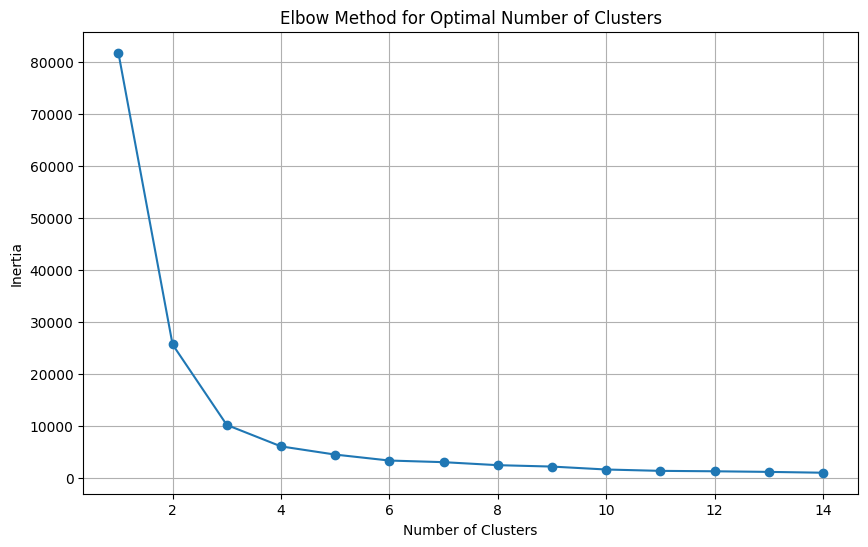

         lat        lon location_cluster
0  40.879548  29.092574                0
1  40.878453  29.096407                0
2  40.873372  29.127030                0
3  40.910136  29.053536                0
4  40.876242  29.096951                0


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/1927401002.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location_cluster'].fillna(-1, inplace=True)


In [22]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Prepare the data for clustering
# Extract latitude and longitude from your DataFrame
location_data = df[['lat', 'lon']].dropna()

# Step 2: Standardize the coordinates
scaler = StandardScaler()
location_scaled = scaler.fit_transform(location_data)

# Step 3: Determine the optimal number of clusters (optional step)
# the elbow method to find the optimal number of clusters
inertia = []
cluster_range = range(1, 15)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(location_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Step 4: Fit the KMeans model with an appropriate number of clusters
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
location_data['location_cluster'] = kmeans.fit_predict(location_scaled)

if 'location_cluster' in df.columns:
    df.drop(columns=['location_cluster'], inplace=True)

# Step 6: Assign cluster labels back to the main DataFrame
df = df.join(location_data[['location_cluster']])

# Step 7: Handle NaN values if there were any rows without lat/lon
df['location_cluster'].fillna(-1, inplace=True)

# Step 8: Convert cluster labels to categorical data type
df['location_cluster'] = df['location_cluster'].astype('category')

# Display the updated DataFrame with the new feature
print(df[['lat', 'lon', 'location_cluster']].head())


In [23]:
# Display the data types of each column
print(df.dtypes)


id                                  int64
categoryTypeName                   object
tradeTypeName                      object
estateTypeName                     object
title                              object
                                   ...   
Aile Sağlığı Merkezi_distance     float64
Özel Hastane_distance             float64
Devlet Hastanesi_distance         float64
Şehir Hastanesi_distance          float64
location_cluster                 category
Length: 117, dtype: object


In [24]:
# Print out numerical features
numerical_features = df.select_dtypes(include='number').columns
print(numerical_features)


Index(['id', 'ilanda_kalis_suresi', 'previousPrice', 'price', 'tlPrice',
       'firstPrice', 'differenceRate', 'squareMeterPrice', 'net_square',
       'gross_square', 'average_household_size', 'population_density',
       'population_count_2021', 'population_growth_rate',
       'social_assistance_yes', 'social_assistance_no',
       'average_gross_area_m2', 'average_net_area_m2', 'sample_size',
       'socio_demographic_score', 'socio_economic_score',
       'risk_perception_attitudes', 'values_score', 'overall_score',
       'district_name_encoded', 'locality_name_encoded', 'town_name_encoded',
       'city.id', 'district.id', 'locality.id', 'town.id', 'lat', 'lon',
       'distance_to_park', 'distance_to_mall', 'rail_distance', 'lat_rank',
       'lon_rank', 'distance_to_sea', 'health_service_distance',
       'Eczane_distance', 'Diş Hekimi_distance',
       'Özel Ağız ve Diş Sağlığı Merkezleri_distance',
       'Doktor/Muayenehane_distance', 'Aile Sağlığı Merkezi_distance',
     

## Removing duplicate columns

In [25]:
# Check for duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)


Duplicate columns found: Index(['id'], dtype='object')


In [26]:
# Drop the duplicate column
df.drop(columns=['id'], inplace=True)


In [27]:
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)

In [28]:
print(df.columns)

Index(['categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title', 'url',
       'images', 'locationSummary', 'quickInfos', 'description',
       'ilanda_kalis_suresi',
       ...
       'health_service_distance', 'Eczane_distance', 'Diş Hekimi_distance',
       'Özel Ağız ve Diş Sağlığı Merkezleri_distance',
       'Doktor/Muayenehane_distance', 'Aile Sağlığı Merkezi_distance',
       'Özel Hastane_distance', 'Devlet Hastanesi_distance',
       'Şehir Hastanesi_distance', 'location_cluster'],
      dtype='object', length=115)


## Flattening lists

In [29]:
# Flatten nested lists in DataFrame
def flatten_nested_lists(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) else x)
    return df

df = flatten_nested_lists(df)

def flatten_nested_dicts(df):
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, dict)).all():
            df[col] = df[col].apply(lambda x: list(x.values())[0])
    return df

df = flatten_nested_dicts(df)

# Define preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define which columns are numerical and categorical
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
processed_data = preprocessor.fit_transform(df)

# Convert the processed data back to a DataFrame
processed_df = pd.DataFrame(processed_data)



# Step 3: Further Data Cleaning, Preprocessing

In [30]:
# Filling missing values for numerical features with the mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.mean()))

# For categorical features, fill missing values with the mode (most common value)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode().iloc[0]))


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/3797752546.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode().iloc[0]))


In [31]:
# Define a threshold for rare categories
threshold = 0.01  # Categories with less than 1% frequency will be combined

# Combine rare categories for categoryTypeName
category_type_counts = df['categoryTypeName'].value_counts(normalize=True)
rare_category_types = category_type_counts[category_type_counts < threshold].index
df['categoryTypeName'] = df['categoryTypeName'].apply(lambda x: 'Other' if x in rare_category_types else x)

# Combine rare categories for estateTypeName
estate_type_counts = df['estateTypeName'].value_counts(normalize=True)
rare_estate_types = estate_type_counts[estate_type_counts < threshold].index
df['estateTypeName'] = df['estateTypeName'].apply(lambda x: 'Other' if x in rare_estate_types else x)

df = pd.get_dummies(df, columns=['categoryTypeName', 'estateTypeName'], drop_first=False)


In [32]:
import re
df['build_age'] = df['build_age'].apply(lambda x: int(re.findall('\d+', x)[0]) if pd.notnull(x) else x)


In [33]:
# Function to convert room_count like "4+1" into an integer by summing the parts
def convert_room_count_to_int(room_count):
    if pd.isnull(room_count):
        return None  # Handle missing values
    parts = room_count.split('+')
    try:
        # Convert each part to integer and sum them
        return sum(int(part) for part in parts)
    except ValueError:
        # Handle edge cases where conversion to integer might fail
        return None

df['room_count'] = df['room_count'].apply(convert_room_count_to_int)


## USD Price

In [34]:
import usd_try
#usd_try.update_usd_data()

# Load your USD rates data
usd_rates_df = pd.read_csv('usd_try_rates.csv')

# Ensure the 'Date' column is in datetime format, specifying utc=True
usd_rates_df['Date'] = pd.to_datetime(usd_rates_df['Date'], errors='coerce', utc=True)

# Drop rows with NaT in the 'Date' column
usd_rates_df = usd_rates_df.dropna(subset=['Date'])

# Check for any NaT values in the Date column
if usd_rates_df['Date'].isnull().any():
    print("Warning: There are NaT values in the 'Date' column. Check your data.")

# Iterate through your main DataFrame (df)
for index, row in df.iterrows():
    # Check if 'is_active' exists or is missing (NaN), if missing, fallback to 'created_at'
    if pd.isna(row.get('is_active', None)) or not row['is_active']:
        # If 'is_active' is missing or False, fallback to using 'created_at' to determine the rate
        #print(f"Warning: 'is_active' is missing or False, using 'created_at' for row {index}")
        
        # Check if 'ilan_bitis' exists and is valid
        if pd.isna(row.get('ilan_bitis', None)):  # Check if 'ilan_bitis' is missing or NaN
            # Fallback to 'created_at' if 'ilan_bitis' is not available
            #print(f"Warning: 'ilan_bitis' is missing, using 'created_at' instead for row {index}")
            ilan_bitis_date = pd.to_datetime(row['created_at'])
        else:
            # Use 'ilan_bitis' if it exists
            ilan_bitis_date = pd.to_datetime(row['ilan_bitis'])

        # Ensure ilan_bitis_date is a valid Timestamp
        if not isinstance(ilan_bitis_date, pd.Timestamp):
            print(f"Error: ilan_bitis_date is not a valid Timestamp: {ilan_bitis_date}")
            continue
        
        # Convert ilan_bitis_date to UTC for comparison
        ilan_bitis_date = ilan_bitis_date.tz_localize('UTC')

        # Find the closest date to ilan_bitis_date
        closest_index = (usd_rates_df['Date'] - ilan_bitis_date).abs().idxmin()
        closest_rate = usd_rates_df.at[closest_index, 'USD/TRY']
        latest_rate = closest_rate

    else:
        # If 'is_active' exists and is True, use the latest rate
        latest_rate = usd_rates_df.iloc[-1]['USD/TRY']

    # Calculate usd_price
    usd_price = row['price'] / latest_rate
    df.at[index, 'usd_price'] = usd_price


## Moving Estate Index

In [35]:
# Check if 'ilan_bitis' exists in the DataFrame
if 'ilan_bitis' in df.columns:
    df['ilan_bitis'] = pd.to_datetime(df['ilan_bitis'], errors='coerce')  # Coerce invalid values to NaT
else:
    # If 'ilan_bitis' does not exist, create a default column or handle it as needed
    print("Warning: 'ilan_bitis' column is missing in the DataFrame.")

# Ensure that 'created_at' is in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Create a DataFrame to hold the mean prices by date
date_range = pd.date_range(start=df['created_at'].min(), end=pd.Timestamp.now())
mean_price_by_date = pd.DataFrame(index=date_range, columns=['mean_price'])

# Calculate active ads for each date
for date in date_range:
    if 'ilan_bitis' in df.columns:
        active_ads = df[(df['created_at'] <= date) & (df['ilan_bitis'] >= date)]
    else:
        active_ads = df[df['created_at'] <= date]  # If 'ilan_bitis' is missing, consider only 'created_at'

    # If there are active ads, calculate the mean price for that date
    if not active_ads.empty:
        mean_price_by_date.at[date, 'mean_price'] = active_ads['usd_price'].mean()
    else:
        mean_price_by_date.at[date, 'mean_price'] = None  # Handle case with no active ads

# Forward fill to ensure all future dates inherit the last available mean price
mean_price_by_date['mean_price'].ffill(inplace=True)

# Check the last date and fill with the latest mean price if not present
if pd.Timestamp.now() not in mean_price_by_date.index:
    mean_price_by_date.loc[pd.Timestamp.now()] = mean_price_by_date['mean_price'].iloc[-1]

# Calculate the total mean price if both 'ilan_bitis' and 'is_active' are missing
total_mean_price = df['usd_price'].mean()

# Map the moving_estate_index back to the original DataFrame
df['moving_estate_index'] = df.apply(
    lambda row: mean_price_by_date['mean_price'].loc[row['ilan_bitis']] if 'ilan_bitis' in row and pd.notna(row['ilan_bitis']) and 'is_active' in row else total_mean_price,
    axis=1
)

# USD PRICE / MEAN USD PRICE 
df['usd_price/index'] = df['usd_price'] / df['moving_estate_index']
df['usd_price/index'].fillna(0, inplace=True)

df['usd_price/index'] = np.log(df['usd_price/index'])


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/2579761226.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_price_by_date['mean_price'].ffill(inplace=True)
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_1657/2579761226.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mea

In [36]:
# Function to extract number from strings for 'floor_number' and 'floor_count'
def extract_number_from_string(s):
    # If the string is 'ground floor' or similar, return 0
    if pd.isnull(s):
        return None
    if 'ground' in s.lower():
        return 0
    # Extract number from string
    nums = re.findall('\d+', s)
    return int(nums[0]) if nums else None

# Apply the function to the 'floor_number' and 'floor_count' columns
df['floor_number'] = df['floor_number'].apply(extract_number_from_string)
df['floor_count'] = df['floor_count'].apply(extract_number_from_string)

df['floor_count'] = df['floor_count'].fillna(df['floor_count'].median())


In [37]:

# Define a threshold for rare categories
threshold = 0.01  # Categories with less than 1% frequency will be combined

# Combine rare heating types
heating_type_counts = df['heating_type'].value_counts(normalize=True)
rare_heating_types = heating_type_counts[heating_type_counts < threshold].index
df['heating_type'] = df['heating_type'].apply(lambda x: 'Other' if x in rare_heating_types else x)

# Combine rare build statuses similarly
build_status_counts = df['build_status'].value_counts(normalize=True)
rare_build_statuses = build_status_counts[build_status_counts < threshold].index
df['build_status'] = df['build_status'].apply(lambda x: 'Other' if x in rare_build_statuses else x)

# Reapply one-hot encoding
df = pd.get_dummies(df, columns=['heating_type', 'build_status'], drop_first=False)


print(df.columns)


Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active',
       ...
       'moving_estate_index', 'usd_price/index', 'heating_type_Kombi Doğalgaz',
       'heating_type_Merkezi (Pay Ölçer)', 'heating_type_Merkezi Doğalgaz',
       'heating_type_Other', 'heating_type_Yerden Isıtma',
       'build_status_Other', 'build_status_Sıfır', 'build_status_İkinci El'],
      dtype='object', length=129)


In [38]:
df.columns

Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active',
       ...
       'moving_estate_index', 'usd_price/index', 'heating_type_Kombi Doğalgaz',
       'heating_type_Merkezi (Pay Ölçer)', 'heating_type_Merkezi Doğalgaz',
       'heating_type_Other', 'heating_type_Yerden Isıtma',
       'build_status_Other', 'build_status_Sıfır', 'build_status_İkinci El'],
      dtype='object', length=129)

In [39]:
"""# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Extracting columns for estate types and heating types
estate_type_columns = [col for col in df.columns if 'estateTypeName_' in col]
heating_type_columns = [col for col in df.columns if 'heating_type_' in col]

# Melt the DataFrame for estate types
estate_type_df = df.melt(value_vars=estate_type_columns)
estate_type_df = estate_type_df[estate_type_df['value'] == 1]

# Melt the DataFrame for heating types
heating_type_df = df.melt(value_vars=heating_type_columns)
heating_type_df = heating_type_df[heating_type_df['value'] == 1]

# Plotting bar charts for Estate Types
plt.figure(figsize=(14, 7))
sns.countplot(data=estate_type_df, x='variable')
plt.title('Frequency of Each Estate Type')
plt.xticks(rotation=90)
plt.xlabel('Estate Type')
plt.ylabel('Count')
plt.show()

# Plotting bar charts for Heating Types
plt.figure(figsize=(14, 7))
sns.countplot(data=heating_type_df, x='variable')
plt.title('Frequency of Each Heating Type')
plt.xticks(rotation=90)
plt.xlabel('Heating Type')
plt.ylabel('Count')
plt.show()

if 'price' in df.columns:
    plt.figure(figsize=(14, 7))
    for col in estate_type_columns:
        if df[col].sum() > 0:  
            sns.boxplot(data=df[df[col] == 1], x='price')
            plt.title(f'Price Distribution for {col}')
            plt.xlabel('Price')
            plt.show()

if 'price' in df.columns:
    plt.figure(figsize=(14, 7))
    for col in heating_type_columns:
        if df[col].sum() > 0:  
            sns.boxplot(data=df[df[col] == 1], x='price')
            plt.title(f'Price Distribution for {col}')
            plt.xlabel('Price')
            plt.show()
"""

'# Set the aesthetics for the plots\nsns.set(style="whitegrid")\n\n# Extracting columns for estate types and heating types\nestate_type_columns = [col for col in df.columns if \'estateTypeName_\' in col]\nheating_type_columns = [col for col in df.columns if \'heating_type_\' in col]\n\n# Melt the DataFrame for estate types\nestate_type_df = df.melt(value_vars=estate_type_columns)\nestate_type_df = estate_type_df[estate_type_df[\'value\'] == 1]\n\n# Melt the DataFrame for heating types\nheating_type_df = df.melt(value_vars=heating_type_columns)\nheating_type_df = heating_type_df[heating_type_df[\'value\'] == 1]\n\n# Plotting bar charts for Estate Types\nplt.figure(figsize=(14, 7))\nsns.countplot(data=estate_type_df, x=\'variable\')\nplt.title(\'Frequency of Each Estate Type\')\nplt.xticks(rotation=90)\nplt.xlabel(\'Estate Type\')\nplt.ylabel(\'Count\')\nplt.show()\n\n# Plotting bar charts for Heating Types\nplt.figure(figsize=(14, 7))\nsns.countplot(data=heating_type_df, x=\'variable\')

In [40]:
# Print out numerical features
numerical_features = df.select_dtypes(include='number').columns
print(numerical_features)


Index(['ilanda_kalis_suresi', 'previousPrice', 'price', 'tlPrice',
       'firstPrice', 'differenceRate', 'squareMeterPrice', 'net_square',
       'gross_square', 'room_count', 'build_age', 'floor_number',
       'floor_count', 'average_household_size', 'population_density',
       'population_count_2021', 'population_growth_rate',
       'social_assistance_yes', 'social_assistance_no',
       'average_gross_area_m2', 'average_net_area_m2', 'sample_size',
       'socio_demographic_score', 'socio_economic_score',
       'risk_perception_attitudes', 'values_score', 'overall_score',
       'district_name_encoded', 'locality_name_encoded', 'town_name_encoded',
       'city.id', 'district.id', 'locality.id', 'town.id', 'lat', 'lon',
       'distance_to_park', 'distance_to_mall', 'rail_distance', 'lat_rank',
       'lon_rank', 'distance_to_sea', 'health_service_distance',
       'Eczane_distance', 'Diş Hekimi_distance',
       'Özel Ağız ve Diş Sağlığı Merkezleri_distance',
       'Doktor/Mu

## Exploratory Data Analysis (EDA)

In [41]:
"""# Histograms for numerical features
numerical_features = ['previousPrice', 'price', 'tlPrice', 'firstPrice', 'differenceRate',
                    'squareMeterPrice', 'net_square', 'gross_square', 'room_count',
                    'build_age', 'floor_number', 'floor_count']

df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Boxplots for numerical features to spot outliers
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(df[var], ax=subplot)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Boxplots Showing Outliers in Numerical Features')
plt.show()

# Correlation matrix of numerical features
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()"""

'# Histograms for numerical features\nnumerical_features = [\'previousPrice\', \'price\', \'tlPrice\', \'firstPrice\', \'differenceRate\',\n                    \'squareMeterPrice\', \'net_square\', \'gross_square\', \'room_count\',\n                    \'build_age\', \'floor_number\', \'floor_count\']\n\ndf[numerical_features].hist(bins=15, figsize=(15, 10), layout=(4, 3))\nplt.subplots_adjust(hspace=0.5)\nplt.suptitle(\'Distribution of Numerical Features\')\nplt.show()\n\n# Boxplots for numerical features to spot outliers\nfig, ax = plt.subplots(4, 3, figsize=(15, 10))\nfor var, subplot in zip(numerical_features, ax.flatten()):\n    sns.boxplot(df[var], ax=subplot)\nplt.subplots_adjust(hspace=0.5)\nplt.suptitle(\'Boxplots Showing Outliers in Numerical Features\')\nplt.show()\n\n# Correlation matrix of numerical features\ncorrelation_matrix = df[numerical_features].corr()\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap=\'coolwarm\', fmt=".2f")\nplt.title(

# Step 4: Feature Engineering

## NLTK description keyword analysis

In [42]:
#df


In [43]:
# Adding a few more features
## Description Length
df['description_length'] = df['description'].apply(len)

## Unique Amenities in Description
amenities = ['havuzlu', 'balkon', 'teras', 'asansörlü', 'güvenlik', 'eşyalı']
for amenity in amenities:
    df[f'amenity_{amenity}'] = df['description'].apply(lambda x: 1 if amenity in x.lower() else 0)

## Province Score - to be done

## Listing age days
df['listing_age_days'] = (pd.to_datetime('today') - pd.to_datetime(df['created_at'])).dt.days
df['days_since_update'] = (pd.to_datetime('today') - pd.to_datetime(df['updated_at'])).dt.days

df['is_furnished'] = df['furniture_status'].apply(lambda x: 1 if x == 'Furnished' else 0)
df['is_mortgageable'] = df['mortgage_status'].apply(lambda x: 1 if x == 'Yes' else 0)

df['bath_count'] = pd.to_numeric(df['bath_count'], errors='coerce').fillna(0)
df['balcony_count'] = pd.to_numeric(df['balcony_count'], errors='coerce').fillna(0)

df['credit_suitable'] = df['suitability_for_credit'].apply(lambda x: 1 if x == 'Yes' else 0)
df['investment_suitable'] = df['suitability_for_investor'].apply(lambda x: 1 if x == 'Yes' else 0)

df['image_count'] = df['images'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

In [44]:
# 1. Room to Bathroom Ratio
# Calculate the ratio of rooms to bathrooms
df['room_to_bathroom_ratio'] = df.apply(lambda row: row['room_count'] / row['bath_count'] if row['bath_count'] > 0 else np.nan, axis=1)

# 2. Floor Ratio
# Ratio of floor number to total floor count
df['floor_ratio'] = df.apply(lambda row: row['floor_number'] / row['floor_count'] if row['floor_count'] > 0 else np.nan, axis=1)

# 3. Amenity Score
# Composite amenity score based on selected amenities
df['amenity_score'] = df[['amenity_havuzlu', 'amenity_balkon', 'amenity_güvenlik']].sum(axis=1)

# 4. Age to Floor Ratio
# Ratio of building age to the total number of floors
df['age_to_floor_ratio'] = df.apply(lambda row: row['build_age'] / row['floor_count'] if row['floor_count'] > 0 else np.nan, axis=1)

# 6. Net to Gross Area Ratio
# Calculate net to gross area ratio
df['net_to_gross_ratio'] = df.apply(lambda row: row['net_square'] / row['gross_square'] if row['gross_square'] > 0 else np.nan, axis=1)

# 7. Average Room Size
# Average room size derived from net square footage
df['average_room_size'] = df.apply(lambda row: row['net_square'] / row['room_count'] if row['room_count'] > 0 else np.nan, axis=1)

# 8. Unique Word Count
# Count the unique words in the description
df['unique_word_count'] = df['description'].apply(lambda desc: len(set(desc.split())) if isinstance(desc, str) else 0)

# 9. Positive Adjective Count
# Define a set of positive adjectives for the count, tailored for Turkish real estate listings
positive_adjectives = [
    'lüks', 'şahane', 'geniş', 'yeni','yatırım','yepyeni', 'ulaşımı kolay', 'yatırıma uygun', 'manzaralı', 'bakımlı',
    'güvenlikli', 'asansörlü', 'çift banyolu', 'balkonlu', 'teraslı', 'havuzlu', 'modern', 'rahat', 'konforlu',
    'güzel', 'temiz', 'özel', 'gözde', 'şık', 'kaliteli', 'sıcak', 'huzurlu'
]

# Count the occurrences of positive adjectives in the description
df['positive_adjective_count'] = df['description'].apply(
    lambda desc: sum(1 for word in desc.lower().split() if word in positive_adjectives) if isinstance(desc, str) else 0
)


# New feature ideas
####### new feature 1 -
df['title_length'] = df['title'].apply(lambda x: len(x.split()))

####### new feature 2 -
keywords = ['lüks', 'deniz manzaralı','yakın','temiz', 'sıfır', 'fırsat', 'yatırımlık', 'acil', 'yatırım', 'yeni', 'modern', 'kaçmaz']

# Count how many keywords appear in each title
df['title_keyword_count'] = df['title'].apply(lambda x: sum(kw in x.lower() for kw in keywords))

####### new feature 3 -
import re
df['number_in_title'] = df['title'].apply(lambda x: 1 if re.search(r'\d', x) else 0)


In [45]:
import nltk
#nltk.download()

In [46]:
# Ensure required resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set up Turkish stopwords
turkish_stopwords = stopwords.words('turkish')

# Function to preprocess text: tokenize, remove non-alphabetic words, stopwords
def preprocess_text(text):
    # Tokenize by word
    tokens = word_tokenize(text, language='turkish')
    # Remove non-alphabetic words and stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in turkish_stopwords]
    return tokens

# Apply preprocessing to each document in the property description column
df['tokens'] = df['description'].fillna('').apply(preprocess_text)

# Flatten the list of tokens and compute frequency distribution
all_tokens = [token for sublist in df['tokens'] for token in sublist]
fdist = FreqDist(all_tokens)

# Get the 25 most common words
most_common_words = fdist.most_common(25)

# Display the most common words and their frequencies
print(most_common_words)


[nltk_data] Downloading package punkt to /Users/melih/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/melih/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('nbsp', 347383), ('yürüme', 23034), ('kat', 15286), ('bir', 15017), ('uygun', 13784), ('daire', 12312), ('yakin', 11371), ('dk', 10869), ('emlak', 10099), ('olup', 9834), ('detayli', 9748), ('satilik', 9735), ('özel', 9255), ('olarak', 8884), ('mutfak', 8821), ('yaşam', 8649), ('banyo', 8626), ('amp', 8116), ('kapali', 7512), ('konumda', 7328), ('ferah', 7196), ('lütfen', 7150), ('otopark', 7149), ('metro', 6997), ('randevu', 6992)]


In [47]:
# List of features to exclude
exclude_features = {'previousValueValid', 'quickInfos', 'suitability_for_investor', 'deed_status', 'square_of_room', 'loan_price', 'subscription_price', 'square_of_balcony', 'balcony_condition', 'parcel_of_land', 'trade', 'opportunity', 'ground_survey', 'category', 'flat_per_floor', 'images', 'tokens', 'square_of_wc', 'balcony_type', 'wc_count', 'suitability_for_credit', 'location', 'tlPrice', 'alternativeValue', 'furniture_status', 'build_type', 'video_navigable', 'trendType', 'previousCurrency', 'currency', 'block_of_buildings', 'trade_type', 'in_site', 'sheet', 'locationSummary', 'tradeTypeName', 'usability', 'updated_at', 'show_unit_price', 'square_of_bath', 'mortgage_status'}

# Filter out unwanted features
df = df.drop(columns=[col for col in exclude_features if col in df.columns])
# df['price_change_percentage'] = ((df['previousPrice'] - df['firstPrice']) / df['firstPrice']) * 100
# df['price_per_square_meter'] = df['firstPrice'] / df['gross_square']

## Iterative Outlier Reduction

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy

def iterative_outlier_removal_with_test_metrics(X_train, y_train, max_iters=10, threshold=2.5):
    # Split training data into train and validation subsets
    """
    X_train = copy.deepcopy(X_train)
    y_train = copy.deepcopy(y_train)
    """
    X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Initialize model and tracking lists
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    metrics_history = {
        "train_mse": [], "val_mse": [], "test_mse": [],
        "train_r2": [], "val_r2": [], "test_r2": [],
        "train_rmse": [], "val_rmse": [], "test_rmse": [],
        "train_ame": [], "val_ame": [], "test_ame": [],
        "size": []
    }

    # Iterative outlier removal
    for i in range(max_iters):
        print(i)
        # Combine training main and validation sets
        X_combined = np.concatenate([X_train_main, X_val])
        y_combined = np.concatenate([y_train_main, y_val])
        
        # Re-split into training and validation sets
        X_train_main, X_val, y_train_main, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
        
        # Train the model on the main training data
        model.fit(X_train_main, y_train_main)
        
        # Predictions for train, validation, and test sets
        y_train_pred = model.predict(X_train_main)
        y_val_pred = model.predict(X_val)

        # Calculate residuals on training data
        residuals = np.abs(y_train_main - y_train_pred)

        # Record metrics
        metrics_history["train_mse"].append(mean_squared_error(y_train_main, y_train_pred))
        metrics_history["val_mse"].append(mean_squared_error(y_val, y_val_pred))

        metrics_history["train_r2"].append(r2_score(y_train_main, y_train_pred))
        metrics_history["val_r2"].append(r2_score(y_val, y_val_pred))

        metrics_history["train_rmse"].append(np.sqrt(metrics_history["train_mse"][-1]))
        metrics_history["val_rmse"].append(np.sqrt(metrics_history["val_mse"][-1]))

        metrics_history["train_ame"].append(mean_absolute_error(y_train_main, y_train_pred))
        metrics_history["val_ame"].append(mean_absolute_error(y_val, y_val_pred))

        metrics_history["size"].append(len(X_train_main))

        # Identify and remove outliers based on residual threshold
        bound = np.percentile(residuals, 100 - threshold)
        outliers = (residuals > bound)
        X_train_main = X_train_main[~outliers]
        y_train_main = y_train_main[~outliers]
        # Stop if no more outliers are found
        if not np.any(outliers):
            break

    # Print results
    print("Iterative Results:")
    for i in range(len(metrics_history["train_mse"])):
        print(
            f"Iteration {i + 1}: Train MSE = {metrics_history['train_mse'][i]:.4f}, Val MSE = {metrics_history['val_mse'][i]:.4f}, "
            f"Train R² = {metrics_history['train_r2'][i]:.4f}, "
            f"Val R² = {metrics_history['val_r2'][i]:.4f}, Train Size = {metrics_history['size'][i]}"
        )

    # Plot all metrics
    metrics_to_plot = ["mse", "r2", "rmse", "ame"]
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(metrics_history[f"train_{metric}"]) + 1), metrics_history[f"train_{metric}"], label=f"Train {metric.upper()}")
        plt.plot(range(1, len(metrics_history[f"val_{metric}"]) + 1), metrics_history[f"val_{metric}"], label=f"Validation {metric.upper()}")
        plt.xlabel("Iteration")
        plt.ylabel(metric.upper())
        plt.title(f"Train, Validation {metric.upper()} over Iterations")
        plt.legend()
        plt.grid()
        plt.show()



# Eliminations of Listing Based on Manual Analysis

In [49]:

# Keywords with and without Turkish characters
keywords_to_filter = [
    'prefabrik', 'kira', 'kiralık', 'kiralik', 'gecekondu', 'devirli', 'devir', 'devren',
    'konteyner', 'kabin', 'masrafı var', 'masrafi var', 'tamire ihtiyacı var', 'tamire ihtiyaci var',
    'tadilata ihtiyacı var', 'tadilata ihtiyaci var', 'tamire ve tadilata ihtiyacı var',
    'tamire ve tadilata ihtiyaci var', 'çatı katı', 'çatı kat', 'cati kati', 'çatı kat', 'ihtiyacı var',
    'ihtiyaci var', 'bakım gereklidir', 'bakim gereklidir', 'gece kondu', 'konteynır', 'bodrum',
    'konteynir', 'kaba sıvalı', 'kaba sivali', 'ahşap ev', 'ahsap ev', 'tamamlanmamış', 'tamamlanmamis', 'RESİMLER TEMSİLİDİR',
    'kaba inşaat', 'KABA İNŞAAT', 'tiny house', 'tinyhouse', 'kara sıva', 'kaba insaat'
]

# Remove rows where the title or description contains any of the specified keywords
df = df[~df['title'].str.contains('|'.join(keywords_to_filter), case=False, na=False) &
                 ~df['description'].str.contains('|'.join(keywords_to_filter), case=False, na=False)]

# Remove rows where 'net_square' is less than x or is NaN
df = df[df['net_square'] >= 45].copy()
df = df[df['net_square'] <= 600].copy()

# Remove rows where 'estateTypeName_Other' is 1
df = df[df['estateTypeName_Other'] != 1].copy()

# price too high too low eliminated
df = df[(df['price'] > 750_000) & (df['price'] <= 100_000_000)].copy()

# Final DataFrame shape
print(f"Filtered DataFrame contains {df.shape[0]} rows and {df.shape[1]} columns.")


Filtered DataFrame contains 35121 rows and 115 columns.


In [50]:
"""
# 1. Keywords presence in title or description
keywords_to_filter = [
    'prefabrik', 'kira', 'kiralık', 'kiralik', 'gecekondu', 'devirli', 'devir', 'devren',
    'konteyner', 'kabin', 'masrafı var', 'masrafi var', 'tamire ihtiyacı var', 'tamire ihtiyaci var',
    'tadilata ihtiyacı var', 'tadilata ihtiyaci var', 'tamire ve tadilata ihtiyacı var',
    'tamire ve tadilata ihtiyaci var', 'çatı katı', 'çatı kat', 'cati kati', 'çatı kat', 'ihtiyacı var',
    'ihtiyaci var', 'bakım gereklidir', 'bakim gereklidir', 'gece kondu', 'konteynır', 'bodrum',
    'konteynir', 'kaba sıvalı', 'kaba sivali', 'ahşap ev', 'ahsap ev', 'tamamlanmamış', 'tamamlanmamis', 'RESİMLER TEMSİLİDİR',
    'kaba inşaat', 'KABA İNŞAAT', 'tiny house', 'tinyhouse', 'kara sıva', 'kaba insaat'
]

df['contains_keywords'] = df['title'].str.contains('|'.join(keywords_to_filter), case=False, na=False) | \
                          df['description'].str.contains('|'.join(keywords_to_filter), case=False, na=False)

# 2. Net square footage range
df['valid_net_square'] = (df['net_square'] >= 45) & (df['net_square'] <= 600)

# 3. Estate type: 'Other'
df['is_estate_other'] = (df['estateTypeName_Other'] == 1)

# 4. Price range
df['valid_price'] = (df['price'] > 750_000) & (df['price'] <= 100_000_000)
"""

"\n# 1. Keywords presence in title or description\nkeywords_to_filter = [\n    'prefabrik', 'kira', 'kiralık', 'kiralik', 'gecekondu', 'devirli', 'devir', 'devren',\n    'konteyner', 'kabin', 'masrafı var', 'masrafi var', 'tamire ihtiyacı var', 'tamire ihtiyaci var',\n    'tadilata ihtiyacı var', 'tadilata ihtiyaci var', 'tamire ve tadilata ihtiyacı var',\n    'tamire ve tadilata ihtiyaci var', 'çatı katı', 'çatı kat', 'cati kati', 'çatı kat', 'ihtiyacı var',\n    'ihtiyaci var', 'bakım gereklidir', 'bakim gereklidir', 'gece kondu', 'konteynır', 'bodrum',\n    'konteynir', 'kaba sıvalı', 'kaba sivali', 'ahşap ev', 'ahsap ev', 'tamamlanmamış', 'tamamlanmamis', 'RESİMLER TEMSİLİDİR',\n    'kaba inşaat', 'KABA İNŞAAT', 'tiny house', 'tinyhouse', 'kara sıva', 'kaba insaat'\n]\n\ndf['contains_keywords'] = df['title'].str.contains('|'.join(keywords_to_filter), case=False, na=False) |                           df['description'].str.contains('|'.join(keywords_to_filter), case=False, na=False)\

# Step 5: Training and Testing Data

[nltk_data] Downloading package stopwords to /Users/melih/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training model...
Model: RandomForestRegressor
MSE: 0.06263629046052
RMSE: 0.25027243248212533
R² score: 0.90069507353393
Number of features used in the model: 45
Provided feature names count:  45
Feature ranking:
1. feature gross_square (0.1181)
2. feature net_square (0.0939)
3. feature bath_count (0.0896)
4. feature average_household_size (0.0754)
5. feature room_count (0.0547)
6. feature social_assistance_yes (0.0478)
7. feature lon (0.0471)
8. feature estateTypeName_daire (0.0344)
9. feature population_count_2021 (0.0254)
10. feature distance_to_mall (0.0226)
11. feature average_room_size (0.0220)
12. feature age_to_floor_ratio (0.0216)
13. feature population_growth_rate (0.0216)
14. feature room_to_bathroom_ratio (0.0209)
15. feature net_to_gross_ratio (0.0205)
16. feature heating_type_Kombi Doğalgaz (0.0170)
17. feature estateTypeName_villa (0.0163)
18. feature lat (0.0163)
19. feature floor_count (0.0154)
20. feature population_density (0.0150)


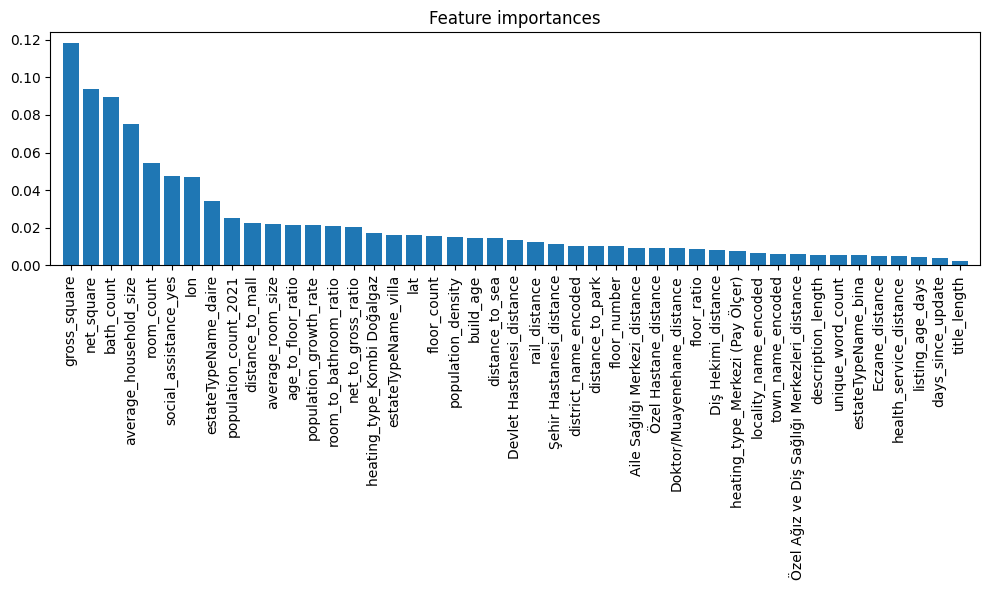

Top 20 Best Valued Listings:
       actual_price  predicted_price  price_difference  percentage_difference  \
13505      0.014545         0.149414          0.134869             927.256357   
19815      0.039863         0.408185          0.368322             923.975708   
34298     -0.011431        -0.104623         -0.093193             815.294265   
8824      -0.011431        -0.104170         -0.092740             811.331244   
34356     -0.006181        -0.053840         -0.047659             771.035597   
23565     -0.011431        -0.097461         -0.086030             752.633810   
19972     -0.065498        -0.552676         -0.487179             743.809335   
6742      -0.038099        -0.318884         -0.280786             736.993416   
8344      -0.065498        -0.547764         -0.482266             736.309708   
13124      0.024749         0.203644          0.178895             722.833358   
34316     -0.068279        -0.561581         -0.493301             722.474328   

{0.25027243248212533, 0.90069507353393}

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# Load the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, framework='pt')

def preprocess_text(text):
    tokens = nltk.word_tokenize(text, language='turkish')
    tokens = [word for word in tokens if word.isalpha() and word.lower() not in turkish_stopwords]
    return ' '.join(tokens)

def batch_sentiment_analysis(texts, batch_size=64):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**batch_encoded)
        predictions = torch.argmax(outputs.logits, dim=1)
        results.extend(predictions.numpy())
    return results

def extract_features(df):
    df['description_preprocessed'] = df['description'].fillna('').apply(preprocess_text)
    # df['description_sentiment'] = batch_sentiment_analysis(df['description_preprocessed'].tolist())
    keywords = ['kelepir', 'acil', 'yürüme', 'yakin', 'uygun', 'metro', 'ferah']
    for keyword in keywords:
        df[f'keyword_{keyword}'] = df['description_preprocessed'].apply(lambda x: 1 if keyword in x.lower() else 0)
    return df


df = extract_features(df)

# Initialize and apply TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=7, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description_preprocessed'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


# Check if TF-IDF features are already present in DataFrame
if not set(tfidf_feature_names).issubset(df.columns):
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

# Ensure the features list includes both original and TF-IDF features
filtered_features = [
    #'location_cluster',
    'average_household_size',
    'population_density',
    'population_count_2021',
    'population_growth_rate',
    'social_assistance_yes',
    'title_length', 'health_service_distance',
    'bath_count', 'description_length', 'listing_age_days', 'days_since_update',
    'lat', 'lon', 'distance_to_sea', 'rail_distance', 'room_to_bathroom_ratio', 'floor_ratio',
    'age_to_floor_ratio', 'net_to_gross_ratio', 'average_room_size', 'unique_word_count',
    'net_square', 'gross_square', 'room_count', 'build_age', 'floor_number', 'floor_count',
    'estateTypeName_bina', 'estateTypeName_daire', 'estateTypeName_villa',
    'heating_type_Kombi Doğalgaz', 'heating_type_Merkezi (Pay Ölçer)',
    'Eczane_distance',  # Distance to nearest pharmacy
    'Diş Hekimi_distance',  # Distance to nearest dentist
    'Özel Ağız ve Diş Sağlığı Merkezleri_distance',  # Distance to nearest private dental health center
    'Doktor/Muayenehane_distance',  # Distance to nearest general practitioner or private clinic
    'Aile Sağlığı Merkezi_distance',  # Distance to nearest family health center
    'Özel Hastane_distance',  # Distance to nearest private hospital
    'Devlet Hastanesi_distance',  # Distance to nearest state hospital
    'Şehir Hastanesi_distance',  # Distance to nearest city hospital
    'district_name_encoded', 'locality_name_encoded', 'town_name_encoded', 'distance_to_park', 'distance_to_mall',
] #+ list(tfidf_feature_names)


"""
# Harun'un feature'ları:
filtered_features = [
    'ilanda_kalis_suresi',
    'gross_square',
    'socio_demographic_score',
    'average_household_size',
    'bath_count',
    'estateTypeName_daire',
    'estateTypeName_villa',
    'distance_to_mall',
    'heating_type_Kombi Doğalgaz',
    'net_square',
    'age_to_floor_ratio',
    'Devlet Hastanesi_distance',
    'lat',
    'lon',
    'distance_to_sea',
    'rail_distance',
    'Aile Sağlığı Merkezi_distance',
    'average_room_size',
    'net_to_gross_ratio',
    'Şehir Hastanesi_distance',
    'Özel Hastane_distance',
    'locality_name_encoded',
    'floor_count',
    'distance_to_park',
    'Doktor/Muayenehane_distance',
    'build_age'
]
"""

# Remove duplicates from the feature list
filtered_features = list(set(filtered_features))

# Filter the DataFrame for outliers

Q1 = df['usd_price/index'].quantile(0.15)
Q3 = df['usd_price/index'].quantile(0.85)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['usd_price/index'] >= lower_bound) & (df['usd_price/index'] <= upper_bound)]

#df_filtered = df.copy()
# Recalculate the numerical features from the filtered DataFrame
X_numerical_filtered = df_filtered[filtered_features].fillna(df_filtered[filtered_features].median())

# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled_filtered = scaler.fit_transform(X_numerical_filtered)

X_filtered = X_numerical_scaled_filtered

# Labels
y_filtered = df_filtered['usd_price/index']

# iterative_outlier_removal_with_test_metrics(X_filtered, y_filtered, max_iters=3, threshold=2)

all_feature_names = filtered_features
# Check for duplicate features in the final feature list
duplicate_features = [feature for feature in all_feature_names if all_feature_names.count(feature) > 1]
if duplicate_features:
    print(f"Duplicate features found: {duplicate_features}")
"""
# Compute the correlation matrix
correlation_matrix = np.corrcoef(X_filtered, rowvar=False)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=filtered_features, yticklabels=filtered_features)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()
"""

"""""
# MARCH MODEL TESTING ON CURRENT ADS
from sklearn.metrics import mean_absolute_error
loaded_model = joblib.load('mart_rf.joblib')
pred_march = loaded_model.predict(X_filtered)
mae = mean_absolute_error(y_filtered, pred_march)  # Mean Absolute Error
mse = mean_squared_error(y_filtered, pred_march)    # Mean Squared Error
r2 = r2_score(y_filtered, pred_march)                # R² score
print(f"MARCH MODEL Mean Absolute Error: {mae}")
print(f"MARCH MODEL Mean Squared Error: {mse}")
print(f"MARCH MODEL R² Score: {r2}")

"""
# Splitting the data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

def train_evaluate_model(model, X_train, X_test, y_train, y_test, feature_names, df_filtered):
    print("Training model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R² score: {r2}')

    # Check if the number of features matches
    print("Number of features used in the model:", X_train.shape[1])
    print("Provided feature names count: ", len(feature_names))

    if len(feature_names) != X_train.shape[1]:
        print("Error: Mismatch in the number of features used for model training and provided feature names.")

        all_features = list(tfidf_feature_names) + [col for col in df.columns if col not in tfidf_feature_names and 'description' not in col]

        # Comparing provided feature names with all possible features derived from data preprocessing
        missing_features = set(all_features) - set(feature_names)
        print("Missing features from provided names:", missing_features)
        extra_features = set(feature_names) - set(all_features)
        print("Extra features in provided names:", extra_features)
    else:
        print("Feature ranking:")
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            for f in range(min(20, len(feature_names))):  # Show top 20 features
                print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

            plt.figure(figsize=(10, 6))
            plt.title("Feature importances")
            plt.bar(range(len(importances)), importances[indices], align='center')
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            plt.xlim([-1, len(importances)])
            plt.tight_layout()
            plt.show()

    # Identify listings where the actual price is less than predicted (good value)
    results_df = pd.DataFrame({
        'actual_price': y_test.tolist(),
        'predicted_price': y_pred,
        'price_difference': y_pred - y_test.tolist(),
        'percentage_difference': ((y_pred - y_test.tolist()) / y_test.tolist()) * 100
    }, index=y_test.index)

    # Filter out extreme outliers where percentage difference is over 1000%
    filtered_good_value_listings = results_df[
        (results_df['percentage_difference'] > 0) &
        (results_df['percentage_difference'] < 1000)
    ]

    # Sort by percentage difference to find the top listings
    top_20_value_listings = filtered_good_value_listings.sort_values(
        by='percentage_difference', ascending=False
    ).head(20)

    # **Add the URL column to the top 20 listings**
    # Fetch the URLs for the top 20 listings from df_filtered
    top_20_urls = df_filtered.loc[top_20_value_listings.index, 'url'].copy()

    # **Modify the URLs by replacing 'imaj.emlakjet.com' with 'www.emlakjet.com'**
    top_20_urls_modified = top_20_urls.apply(
        lambda x: x.replace('https://imaj.emlakjet.com', 'https://www.emlakjet.com') if isinstance(x, str) else x
    )

    # Add the modified URLs to the top 20 listings DataFrame
    top_20_value_listings = top_20_value_listings.copy()
    top_20_value_listings['url'] = top_20_urls_modified.values

    print("Top 20 Best Valued Listings:")
    print(top_20_value_listings[['actual_price', 'predicted_price', 'price_difference', 'percentage_difference', 'url']])
    print("-" * 80)

    # However, to double-check, we can assert that
    # assert df_filtered.loc[top_20_value_listings.index, 'is_active'].all(), "Some top listings are not active."

    # Extract IDs from modified URLs
    top_20_ids = top_20_urls_modified.apply(lambda x: re.findall(r'(\d+)(?:/)?$', x)[0] if isinstance(x, str) else None)

    # **Print and save the IDs and URLs to a TXT file**
    top_20_output = pd.DataFrame({
        'id': top_20_ids,
        'url': top_20_urls_modified
    })

    print("Top 20 Best Valued Listings IDs and URLs:")
    print(top_20_output)

    # **Save to TXT File**
    # Define the output file name
    output_file = 'top_listings_ids_and_urls.txt'

    # Open the file in write mode
    with open(output_file, 'w', encoding='utf-8') as file:
        # Write a header
        file.write("Top 20 Best Valued Listings:\n")
        file.write("="*40 + "\n\n")
        # Iterate through each row and write the ID and URL
        for index, row in top_20_output.iterrows():
            file.write(f"ID: {row['id']}\nURL: {row['url']}\n\n")

    print(f"Top 20 listings IDs and URLs have been saved to '{output_file}'.")
    print("-" * 80)

    return {r2, rmse}


def custom_scoring(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # Combine them in a dictionary or log them as you want
    print(f"MSE: {mse}, RMSE: {rmse}, R²: {r2}, MAE: {mae}")
    return r2  # ADJUST RETURN TO SET OBJECTIVE

def hyperparameter_tuning(X_train, y_train):
    param_dist = {
        'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
        'max_depth': [None, 10, 20, 30, 50, 100],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False],
    }
    model = RandomForestRegressor(random_state=42)
    grid_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=100, 
        cv=5, 
        n_jobs=-1, 
        verbose=2, 
        random_state=42,
        scoring=make_scorer(custom_scoring, greater_is_better=False)
    )

    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters: {grid_search.best_params_}")


#hyperparameter_tuning(X_train_filtered, y_train_filtered)

#Best hyperparameters : {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
#Best hyperparameters : bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300
feature_names = all_feature_names  # This should include all feature names used to form
"""
model = RandomForestRegressor(
    n_estimators = 10, 
    min_samples_split = 5,
    min_samples_leaf =  4,
    max_features = 'sqrt',
    max_depth = 10,
    bootstrap = False,
    random_state=42
)
"""
model = RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42)
train_evaluate_model(model, X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered, feature_names, df_filtered)


Model: RandomForestRegressor
MSE: 102234315875.35577
RMSE: 319741.01375231135
R² score: 0.9827651158684666
Number of features used in the model: 30
Provided feature names count:  30

Model: RandomForestRegressor
MSE: 101809835478.13597
RMSE: 319076.53545526654
R² score: 0.9828366757004031
Number of features used in the model: 25
Provided feature names count:  25

Model: RandomForestRegressor
MSE: 99428632295.75981
RMSE: 315323.06020296045
R² score: 0.9832381041306762
Number of features used in the model: 20
Provided feature names count:  20

Model: RandomForestRegressor
MSE: 117408693023.56415
RMSE: 342649.51922272437
R² score: 0.9802069862455676
Number of features used in the model: 52
Provided feature names count:  52


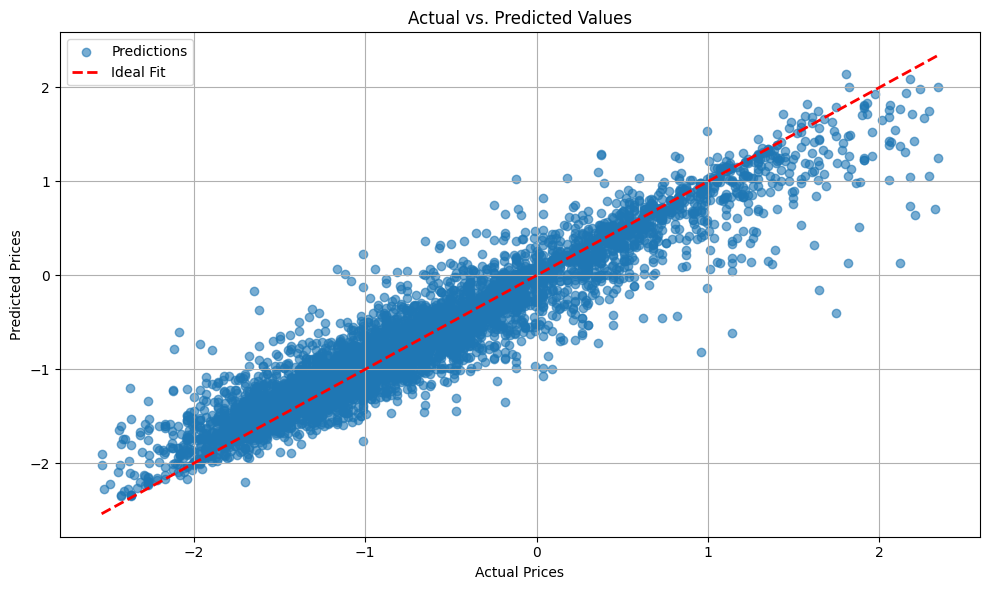

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, model.predict(X_test_filtered), alpha=0.6, label="Predictions")
plt.plot([min(y_test_filtered), max(y_test_filtered)],
         [min(y_test_filtered), max(y_test_filtered)],
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Moving - Train & Test 

Training model...
Model: RandomForestRegressor
MSE: 0.08381526163482862
RMSE: 0.28950865554388633
R² score: 0.8892229837500109
Training model...
Model: RandomForestRegressor
MSE: 0.07517431815535584
RMSE: 0.274179353991791
R² score: 0.8712663239580015
Training model...
Model: RandomForestRegressor
MSE: 0.05615836235417002
RMSE: 0.23697755664655254
R² score: 0.9009261478421422
Training model...
Model: RandomForestRegressor
MSE: 0.05705904215408551
RMSE: 0.2388703459077445
R² score: 0.9045536143330329
Training model...
Model: RandomForestRegressor
MSE: 0.05585883724972719
RMSE: 0.23634474237800845
R² score: 0.9040070027238308
Training model...
Model: RandomForestRegressor
MSE: 0.05617838884044907
RMSE: 0.2370198068526111
R² score: 0.9104346748204485


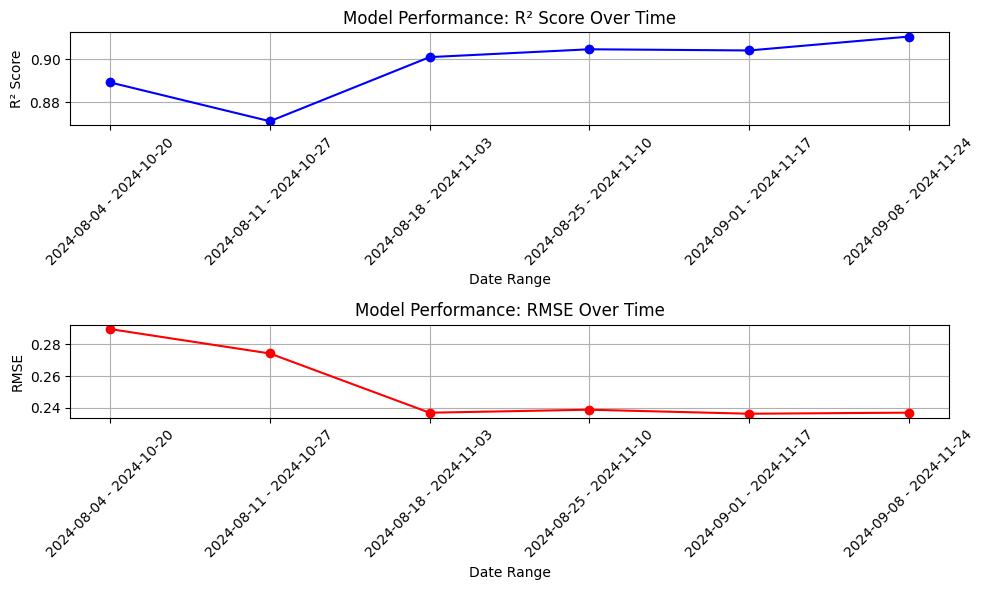

In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to filter data for a given week range
def get_data_for_week(data, start_date, end_date):
    return data[(data['created_at'] >= start_date) & (data['created_at'] < end_date)]

def quick_train_evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R² score: {r2}')
    return {'r2': r2, 'rmse': rmse}

# Function to simulate training and testing over a rolling time window
def train_test_simulation(df_filtered, model, start_week=20, training_weeks=5):
    # Convert 'created_at' to datetime if it's not already in that format
    df_filtered['created_at'] = pd.to_datetime(df_filtered['created_at'])
    
    # Get the latest date in the dataset
    latest_date = df_filtered['created_at'].max()
    
    # Initialize lists to store performance metrics and date labels
    r2_scores = []
    rmse_scores = []
    dates = []
    
    # Loop over the weeks starting from 1 and increasing up to `start_week`
    for i in range(start_week, 0, -1):
        # Calculate the start and end of the training and testing weeks
        test_start_date = latest_date - timedelta(weeks=i)
        test_end_date = test_start_date + timedelta(weeks=1)
        train_start_date = latest_date - timedelta(weeks=i + training_weeks)
        train_end_date = test_start_date
        
        # Filter data for the training and testing periods
        train_data = get_data_for_week(df_filtered, train_start_date, train_end_date)
        test_data = get_data_for_week(df_filtered, test_start_date, test_end_date)
        
        # Prepare the features (X) and target (y) for training and testing
        X_train = train_data[filtered_features]  # Use X_filtered directly
        y_train = train_data['usd_price/index']
        X_test = test_data[filtered_features]    # Use X_filtered directly
        y_test = test_data['usd_price/index']
        
        # Evaluate the model using your custom function
        performance = quick_train_evaluate_model(model, X_train, X_test, y_train, y_test)
        
        # Append performance metrics to the lists
        r2_scores.append(performance['r2'])
        rmse_scores.append(performance['rmse'])
        dates.append(f"{train_start_date.date()} - {test_end_date.date()}")
    
    # Return the performance metrics
    return r2_scores, rmse_scores, dates

# Example usage of the function:
# Assuming `model` is your model object (e.g., a Scikit-learn model) and `df_filtered` is your DataFrame
# Also, `filtered_features` should be pre-defined in your script

r2_scores, rmse_scores, dates = train_test_simulation(df_filtered, model, start_week=6, training_weeks=10)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot R² scores
plt.subplot(2, 1, 1)
plt.plot(dates, r2_scores, marker='o', color='blue', label='R² Score')
plt.xticks(rotation=45)
plt.title('Model Performance: R² Score Over Time')
plt.xlabel('Date Range')
plt.ylabel('R² Score')
plt.grid(True)

# Plot RMSE scores
plt.subplot(2, 1, 2)
plt.plot(dates, rmse_scores, marker='o', color='red', label='RMSE')
plt.xticks(rotation=45)
plt.title('Model Performance: RMSE Over Time')
plt.xlabel('Date Range')
plt.ylabel('RMSE')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Recursive Feature Elimination

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def recursive_feature_elimination():
    # To store results for plotting
    results = {'n_features': [], 'MSE': [], 'RMSE': [], 'AME': [], 'R^2': []}
    feature_importances_history = []

    # Create copies to work on for iterative feature removal
    X_train_iter = X_train_filtered.copy()
    X_test_iter = X_test_filtered.copy()

    # Iteratively remove features and store metrics
    while X_train_iter.shape[1] > 3:  # Ensure at least 3 features remain
        # Train the model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_iter, y_train_filtered)
        
        # Predict and calculate metrics
        y_pred = model.predict(X_test_iter)
        mse = mean_squared_error(y_test_filtered, y_pred)
        rmse = np.sqrt(mse)
        ame = mean_absolute_error(y_test_filtered, y_pred)
        r2 = r2_score(y_test_filtered, y_pred)

        # Store metrics for plotting
        results['n_features'].append(X_train_iter.shape[1])
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        results['AME'].append(ame)
        results['R^2'].append(r2)

        # Get feature importances and store them
        feature_importances = pd.Series(model.feature_importances_, index=range(X_train_iter.shape[1]))
        feature_importances_history.append(feature_importances)

        # Print the metrics at each tier
        print(f"Number of Features: {X_train_iter.shape[1]}")
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, AME: {ame:.4f}, R^2: {r2:.4f}")
        
        # Find the indices of the 3 least important features
        least_important_indices = np.argsort(feature_importances)[:3]

        # Remove the least important features from the arrays (by column index)
        X_train_iter = np.delete(X_train_iter, least_important_indices, axis=1)
        X_test_iter = np.delete(X_test_iter, least_important_indices, axis=1)

        print(results)
        n_features = results['n_features']
        mse = results['MSE']
        rmse = results['RMSE']
        ame = results['AME']
        r2 = results['R^2']

        # Final static plot after all iterations for MSE, RMSE, AME, and R^2
        plt.figure(figsize=(14, 8))

        # Plot MSE
        plt.plot(n_features, mse, label='MSE', marker='o')
        # Plot RMSE
        plt.plot(n_features, rmse, label='RMSE', marker='o')
        # Plot AME
        plt.plot(n_features, ame, label='AME', marker='o')
        # Plot R^2
        plt.plot(n_features, r2, label='R^2', marker='o')

        # Labeling the axes and title
        plt.xlabel('Number of Features')
        plt.ylabel('Metric Value')
        plt.title('Model Metrics vs. Number of Features')

        # Show the legend
        plt.legend()

        # Show grid for better readability
        plt.grid(True)

        # Display the plot
        plt.show()

        
"""
# Plot the feature importances after all iterations
plt.figure(figsize=(14, 8))
for i, feature_importances in enumerate(feature_importances_history):
    plt.plot(feature_importances.index, feature_importances.values, label=f'Iteration {i+1}')

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances at Each Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Final static plot after all iterations for MSE, RMSE, AME, and R^2
plt.ioff()  # Turn off interactive mode
plt.show()
"""

"\n# Plot the feature importances after all iterations\nplt.figure(figsize=(14, 8))\nfor i, feature_importances in enumerate(feature_importances_history):\n    plt.plot(feature_importances.index, feature_importances.values, label=f'Iteration {i+1}')\n\nplt.xlabel('Feature Index')\nplt.ylabel('Importance')\nplt.title('Feature Importances at Each Iteration')\nplt.legend()\nplt.grid(True)\nplt.show()\n\n# Final static plot after all iterations for MSE, RMSE, AME, and R^2\nplt.ioff()  # Turn off interactive mode\nplt.show()\n"

## Cross Validation

In [55]:
# Convert X_filtered from sparse to dense if necessary for neural network models
X_dense = X_filtered.toarray() if hasattr(X_filtered, "toarray") else X_filtered

y = y_filtered

def train_evaluate_model_cv(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

    rmse_scores = np.sqrt(np.abs(mse_scores))

    print(f'Model: {model.__class__.__name__}')
    print(f'Average MSE: {np.mean(mse_scores)}')
    print(f'Average RMSE: {np.mean(rmse_scores)}')
    print(f'Average R² score: {np.mean(r2_scores)}\n')

X_for_cv = X_dense

# List of models to evaluate
models = [
    # LinearRegression(),
    RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
]

# Train and evaluate each model with cross-validation
for model in models:
    train_evaluate_model_cv(model, X_for_cv, y)

Model: RandomForestRegressor
Average MSE: -0.06881699129396908
Average RMSE: 0.2623172004409636
Average R² score: 0.8928016737142686



In [56]:
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define individual models
random_forest = RandomForestRegressor(n_estimators=200, random_state=42)
gradient_boosting = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgboost = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)

### Voting Regressor
print("Evaluating Voting Regressor...")
voting_regressor = VotingRegressor(estimators=[
    ('rf', random_forest),
    ('gb', gradient_boosting),
    ('xgb', xgboost)
])

# Train and evaluate Voting Regressor
voting_regressor.fit(X_train_filtered, y_train_filtered)
y_pred_voting = voting_regressor.predict(X_test_filtered)

# Calculate RMSE and R² for Voting Regressor
rmse_voting = np.sqrt(mean_squared_error(y_test_filtered, y_pred_voting))
r2_voting = r2_score(y_test_filtered, y_pred_voting)
print(f"Voting Regressor RMSE: {rmse_voting}")
print(f"Voting Regressor R² Score: {r2_voting}\n")

### Stacking Regressor
print("Evaluating Stacking Regressor...")
# Meta-model for stacking
meta_model = Ridge()

# Stacking Regressor with base models and meta-model
stacking_regressor = StackingRegressor(estimators=[
    ('rf', random_forest),
    ('gb', gradient_boosting),
    ('xgb', xgboost)
], final_estimator=meta_model, cv=5)

# Train and evaluate Stacking Regressor
stacking_regressor.fit(X_train_filtered, y_train_filtered)
y_pred_stacking = stacking_regressor.predict(X_test_filtered)

# Calculate RMSE and R² for Stacking Regressor
rmse_stacking = np.sqrt(mean_squared_error(y_test_filtered, y_pred_stacking))
r2_stacking = r2_score(y_test_filtered, y_pred_stacking)
print(f"Stacking Regressor RMSE: {rmse_stacking}")
print(f"Stacking Regressor R² Score: {r2_stacking}\n")


Evaluating Voting Regressor...


: 

## Training on Full Data

In [ ]:
def train_evaluate_on_full_data(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)  # Train on the entire dataset
    y_pred = model.predict(X)  # Predict on the same dataset
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print("Training and Testing on Full Dataset:")
    print(f"RMSE: {rmse}")
    print(f"R² score: {r2}")

train_evaluate_on_full_data(X_dense, y)


## Ilanda Kalış Süresi Tahmini

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Filter the DataFrame for passive ads (is_active == False)
df_passive = df[df['is_active'] == False]

# Features and target variable
X = df_passive[['usd_price/index', 'usd_price', 'price', 'bath_count', 'description_length',
                 'lat', 'lon', 'distance_to_sea', 'rail_distance', 
                 'room_to_bathroom_ratio', 'floor_ratio', 'amenity_score', 
                 'age_to_floor_ratio', 'net_to_gross_ratio', 'average_room_size', 
                 'unique_word_count', 'positive_adjective_count', 'net_square', 
                 'gross_square', 'room_count', 'build_age', 'floor_number', 
                 'floor_count', 'differenceRate']]

y = df_passive['ilanda_kalis_suresi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)  # Convert negative MSE to RMSE

# Print cross-validation scores
print(f'Cross-validated RMSE: {cv_rmse}')
print(f'Mean Cross-validated RMSE: {cv_rmse.mean()}')

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics for the test set
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test R² score: {r2}')

## Results Overview

   - Full Data Training and Testing
        RMSE: 155,731
        R² score: 0.996

   - Cross-Validation
        Average RMSE: 420,672
        Average R² score: 0.970

         there is a difference of 264,94 rmse between the full data training and testing and cross-validation results.

         The RMSE increased by about 169.9% when using cross-validation compared to the full data training and testing.
         This indicates that the model may be overfitting to the training data, as the performance on unseen data is significantly worse.

         R² score difference (0.996 vs. 0.970) appear small as R² is often less sensitive to overfitting visually because it is a relative measure of fit.